# Predicting Customer churn for a telecom industry

### Loading Required Packages

In [328]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
%matplotlib inline

import warnings

from imblearn.over_sampling import  SMOTE
from collections import Counter
from sklearn.model_selection import GridSearchCV
from itertools import product
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, train_test_split, KFold
pd.set_option('display.max_columns', None)

from sklearn.ensemble import RandomForestClassifier
import xgboost
from xgboost import XGBClassifier

from sklearn.metrics import f1_score, confusion_matrix,ConfusionMatrixDisplay

### Loading the data into python

In [329]:
data = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
print('The number of rows and columns respectively are :', data.shape)
data.head()

The number of rows and columns respectively are : (7043, 21)


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [330]:
data.head()

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [331]:
data = data.drop(columns=['customerID'])

## Data Cleaning Stage

In [332]:
#checking for missing values
data.isnull().sum()

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [333]:
# Investigate all the values within each Feature 
for column in data:
    unique_values = np.unique(data[column])
    number_of_values = len(unique_values)
    if number_of_values < 10:
        print('The number of values for feature {}: {} --> {}'.format(column, number_of_values,unique_values))
    else:
        print('The number of values for feature {}: {}'.format(column, number_of_values))

The number of values for feature gender: 2 --> ['Female' 'Male']
The number of values for feature SeniorCitizen: 2 --> [0 1]
The number of values for feature Partner: 2 --> ['No' 'Yes']
The number of values for feature Dependents: 2 --> ['No' 'Yes']
The number of values for feature tenure: 73
The number of values for feature PhoneService: 2 --> ['No' 'Yes']
The number of values for feature MultipleLines: 3 --> ['No' 'No phone service' 'Yes']
The number of values for feature InternetService: 3 --> ['DSL' 'Fiber optic' 'No']
The number of values for feature OnlineSecurity: 3 --> ['No' 'No internet service' 'Yes']
The number of values for feature OnlineBackup: 3 --> ['No' 'No internet service' 'Yes']
The number of values for feature DeviceProtection: 3 --> ['No' 'No internet service' 'Yes']
The number of values for feature TechSupport: 3 --> ['No' 'No internet service' 'Yes']
The number of values for feature StreamingTV: 3 --> ['No' 'No internet service' 'Yes']
The number of values for fe

In [334]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

#### Checking for incorrect dataypes

In [335]:
data.head(2)

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   

  PaperlessBilling     PaymentMethod  MonthlyCharges TotalCharges Churn  
0              Yes  Electronic check           29.85        29.85    No  
1               No      Mailed check           56.95       1889.5    No

In [336]:
data.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

#### TotalCharges feature has a wrong datatype

In [337]:

data[data['TotalCharges']==' ']

gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
488   Female              0     Yes        Yes       0           No   
753     Male              0      No        Yes       0          Yes   
936   Female              0     Yes        Yes       0          Yes   
1082    Male              0     Yes        Yes       0          Yes   
1340  Female              0     Yes        Yes       0           No   
3331    Male              0     Yes        Yes       0          Yes   
3826    Male              0     Yes        Yes       0          Yes   
4380  Female              0     Yes        Yes       0          Yes   
5218    Male              0     Yes        Yes       0          Yes   
6670  Female              0     Yes        Yes       0          Yes   
6754    Male              0      No        Yes       0          Yes   

         MultipleLines InternetService       OnlineSecurity  \
488   No phone service             DSL                  Yes   
753                 No              No  No internet service   
936                 No             DSL                  Yes   
1082               Yes              No  No internet service   
1340  No phone service             DSL                  Yes   
3331                No              No  No internet service   
3826               Yes              No  No internet service   
4380                No              No  No internet service   
5218                No              No  No internet service   
6670               Yes             DSL                   No   
6754               Yes             DSL                  Yes   

             OnlineBackup     DeviceProtection          TechSupport  \
488                    No                  Yes                  Yes   
753   No internet service  No internet service  No internet service   
936                   Yes                  Yes                   No   
1082  No internet service  No internet service  No internet service   
1340                  Yes                  Yes                  Yes   
3331  No internet service  No internet service  No internet service   
3826  No internet service  No internet service  No internet service   
4380  No internet service  No internet service  No internet service   
5218  No internet service  No internet service  No internet service   
6670                  Yes                  Yes                  Yes   
6754                  Yes                   No                  Yes   

              StreamingTV      StreamingMovies  Contract PaperlessBilling  \
488                   Yes                   No  Two year              Yes   
753   No internet service  No internet service  Two year               No   
936                   Yes                  Yes  Two year               No   
1082  No internet service  No internet service  Two year               No   
1340                  Yes                   No  Two year               No   
3331  No internet service  No internet service  Two year               No   
3826  No internet service  No internet service  Two year               No   
4380  No internet service  No internet service  Two year               No   
5218  No internet service  No internet service  One year              Yes   
6670                  Yes                   No  Two year               No   
6754                   No                   No  Two year              Yes   

                  PaymentMethod  MonthlyCharges TotalCharges Churn  
488   Bank transfer (automatic)           52.55                 No  
753                Mailed check           20.25                 No  
936                Mailed check           80.85                 No  
1082               Mailed check           25.75                 No  
1340    Credit card (automatic)           56.05                 No  
3331               Mailed check           19.85                 No  
3826               Mailed check           25.35                 No  
4380               Mailed check           20.00                 No

In [338]:
#replace all empty fields with NaNs
data['TotalCharges'] = data['TotalCharges'].replace(' ',np.NaN)

In [339]:
#drop all missing values
data = data.dropna()

In [341]:
#change to appropriate datatype
data['TotalCharges'] = data['TotalCharges'].astype('float')

In [342]:
### create a categorical and numerical columns
numerical_features = data[['MonthlyCharges', 'TotalCharges','SeniorCitizen','tenure']]
categorical_features = data[['gender', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'Churn']]

In [343]:
#check for outliers
numerical_features.describe()

MonthlyCharges  TotalCharges  SeniorCitizen       tenure
count     7032.000000   7032.000000    7032.000000  7032.000000
mean        64.798208   2283.300441       0.162400    32.421786
std         30.085974   2266.771362       0.368844    24.545260
min         18.250000     18.800000       0.000000     1.000000
25%         35.587500    401.450000       0.000000     9.000000
50%         70.350000   1397.475000       0.000000    29.000000
75%         89.862500   3794.737500       0.000000    55.000000
max        118.750000   8684.800000       1.000000    72.000000

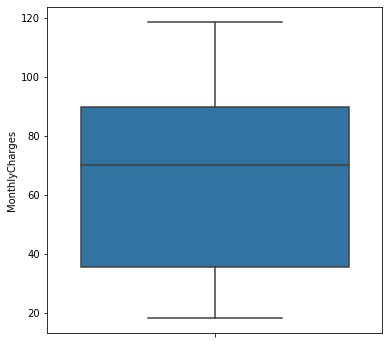

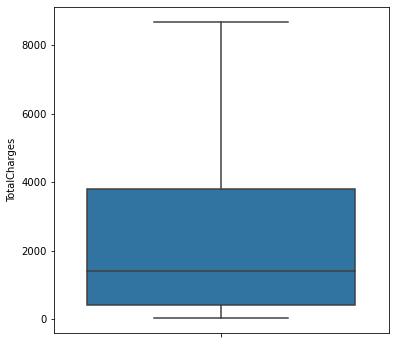

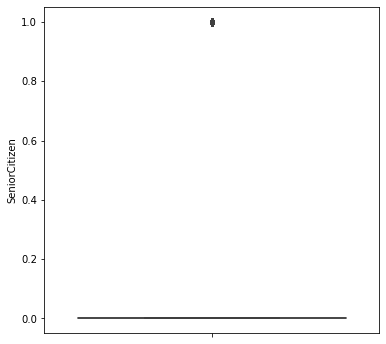

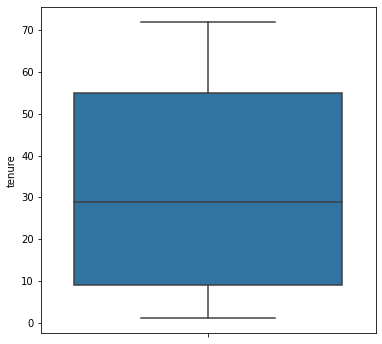

In [344]:
for num in numerical_features:
    plt.figure(figsize=(6,6))
    ax = sns.boxplot(y=num,data=numerical_features)

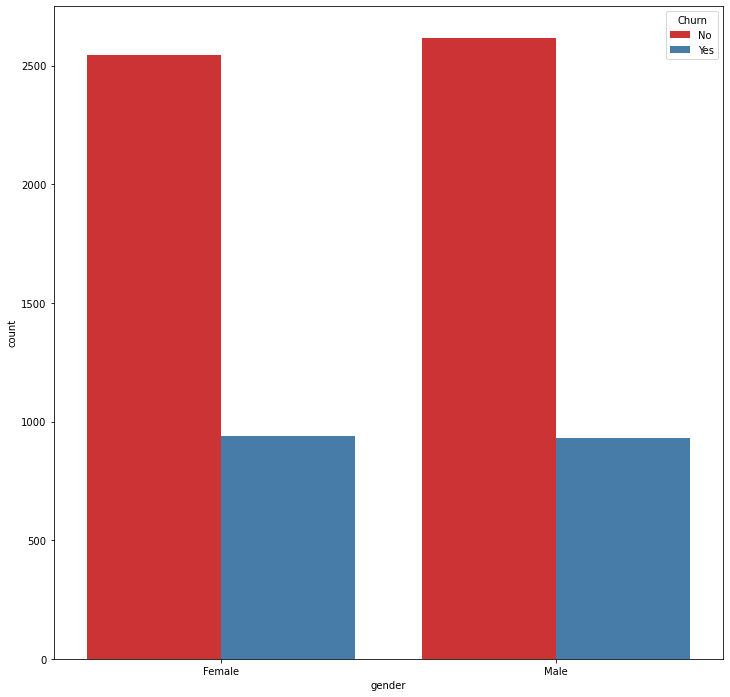

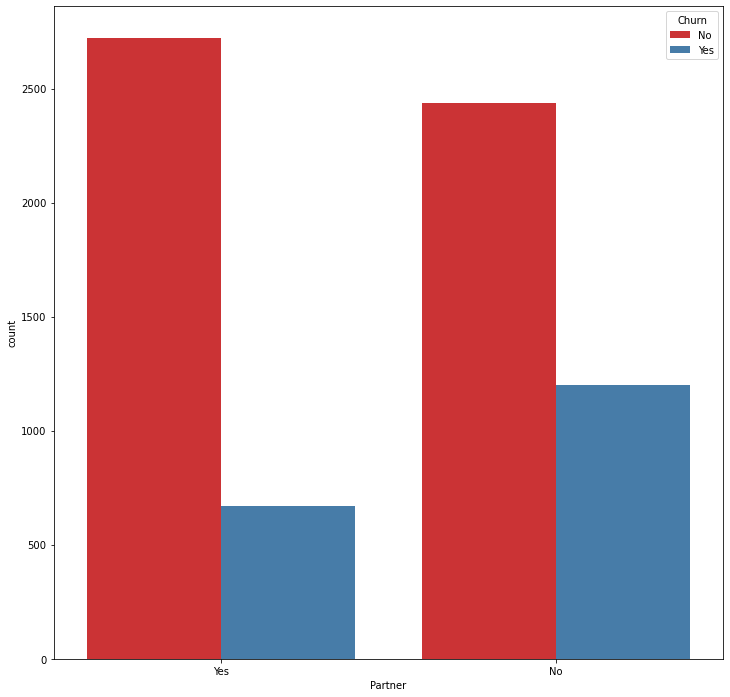

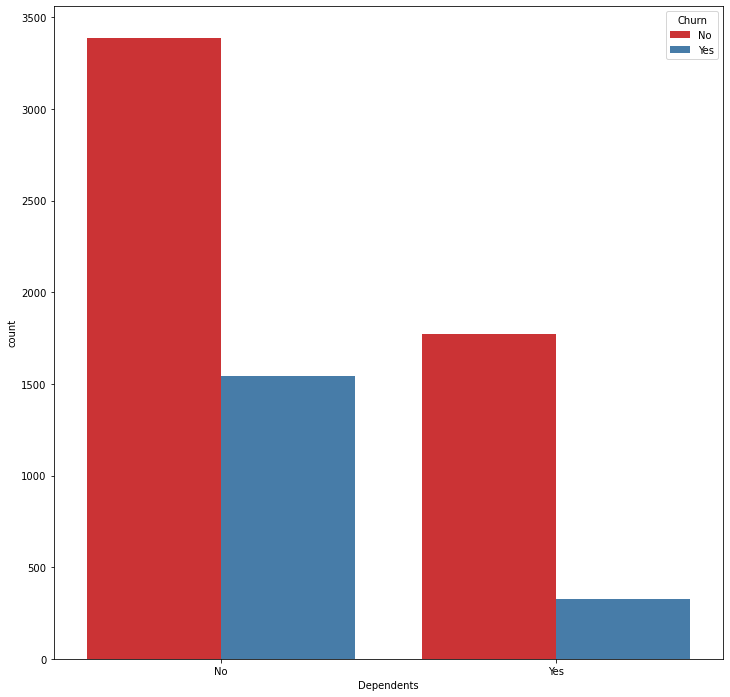

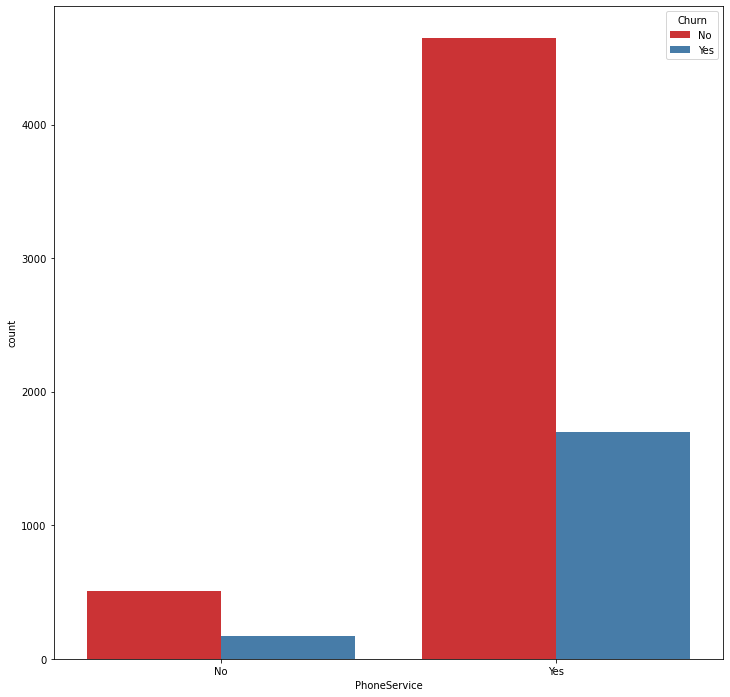

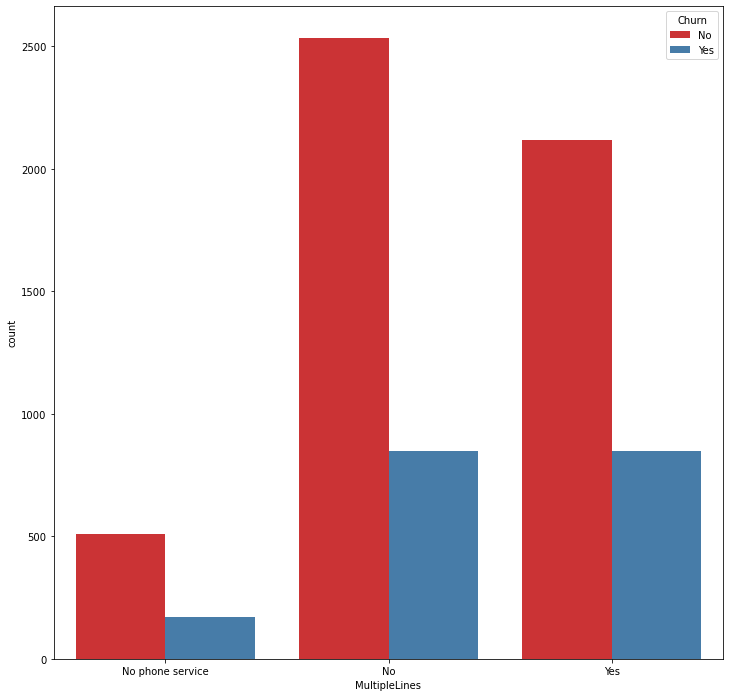

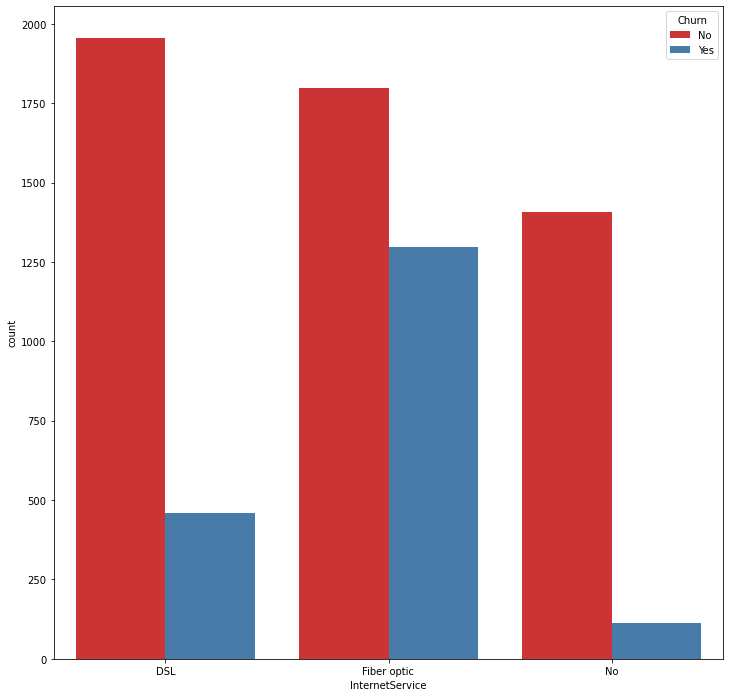

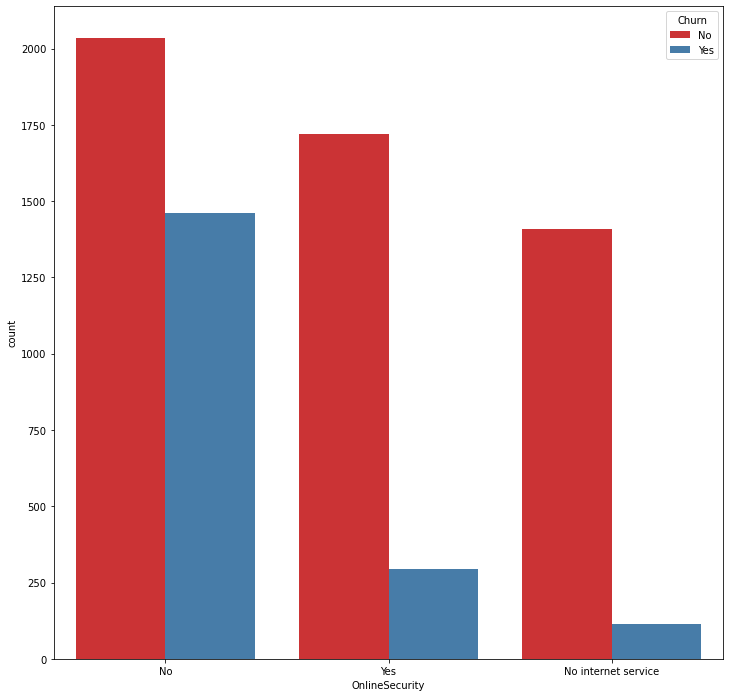

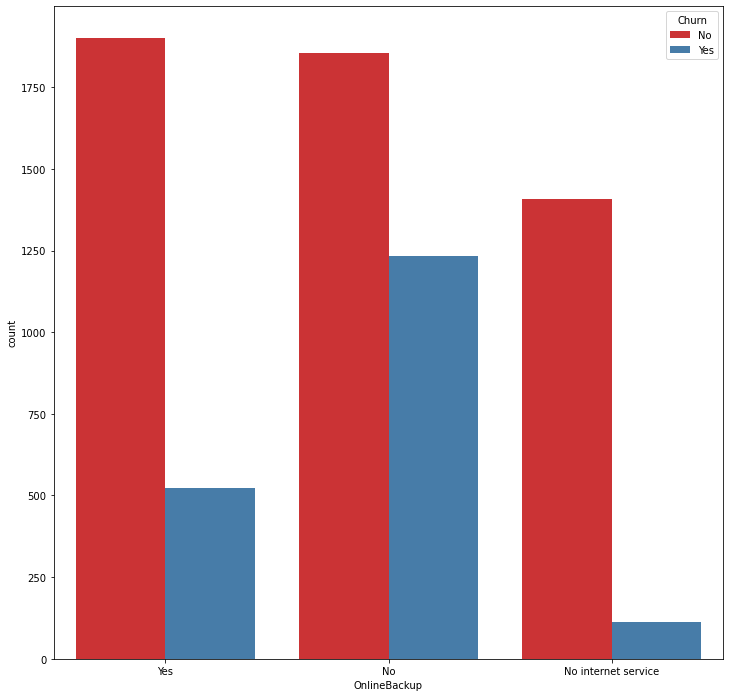

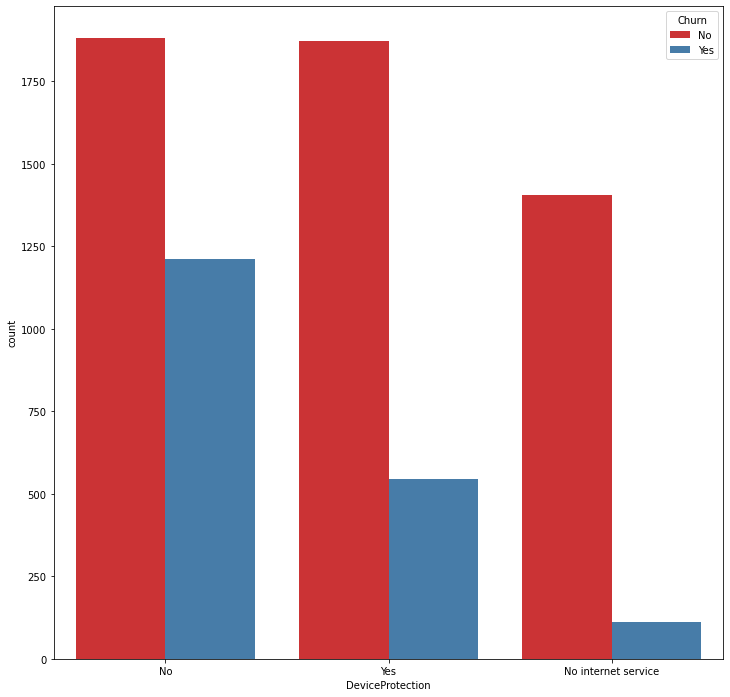

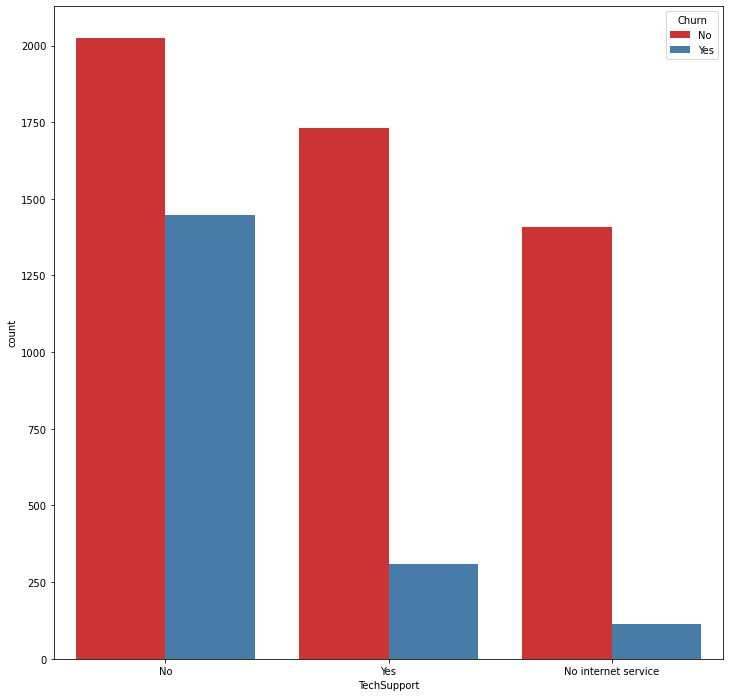

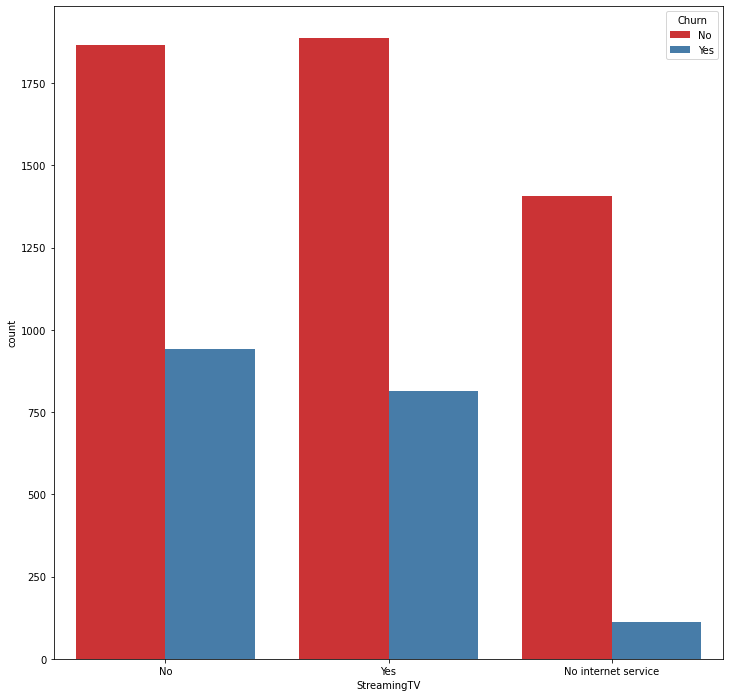

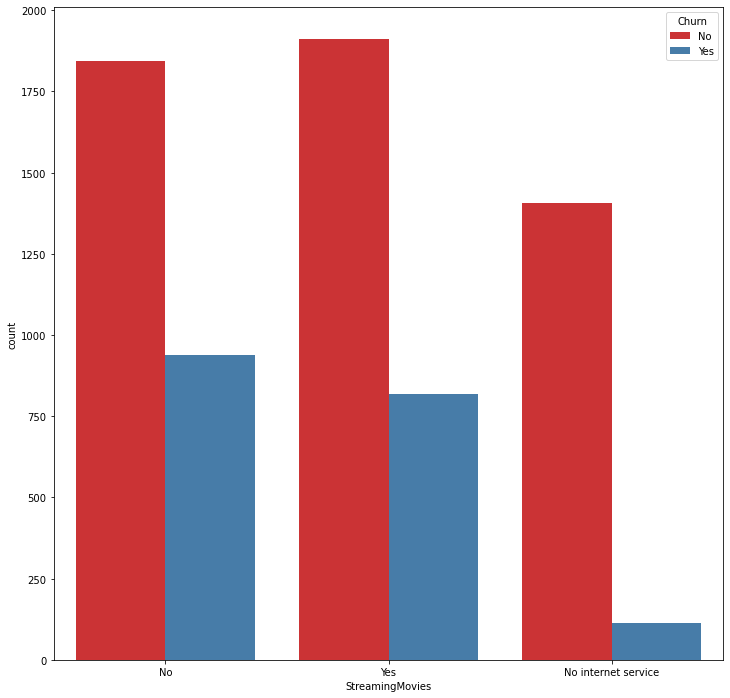

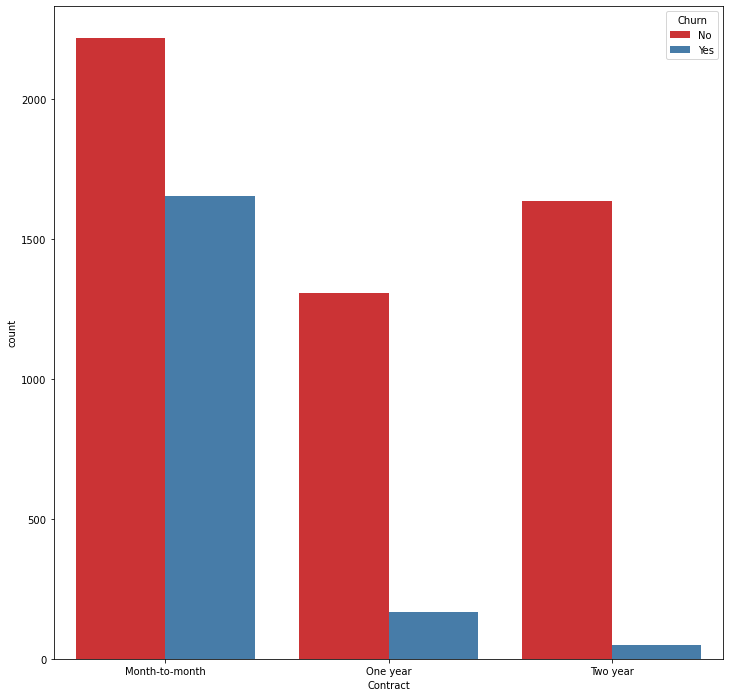

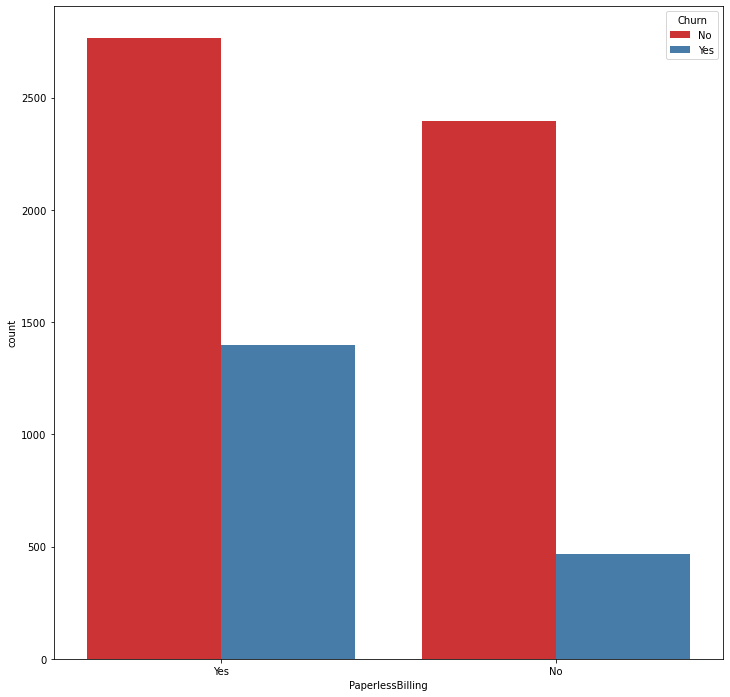

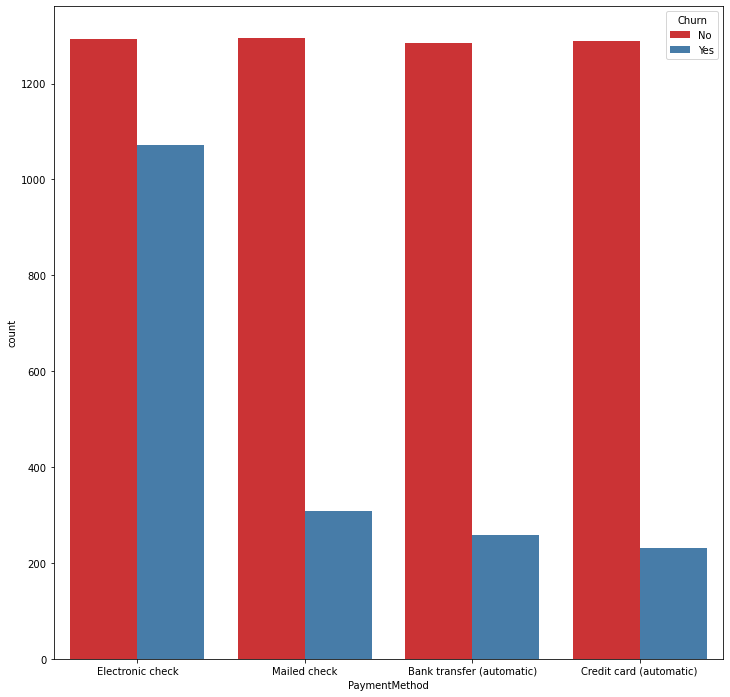

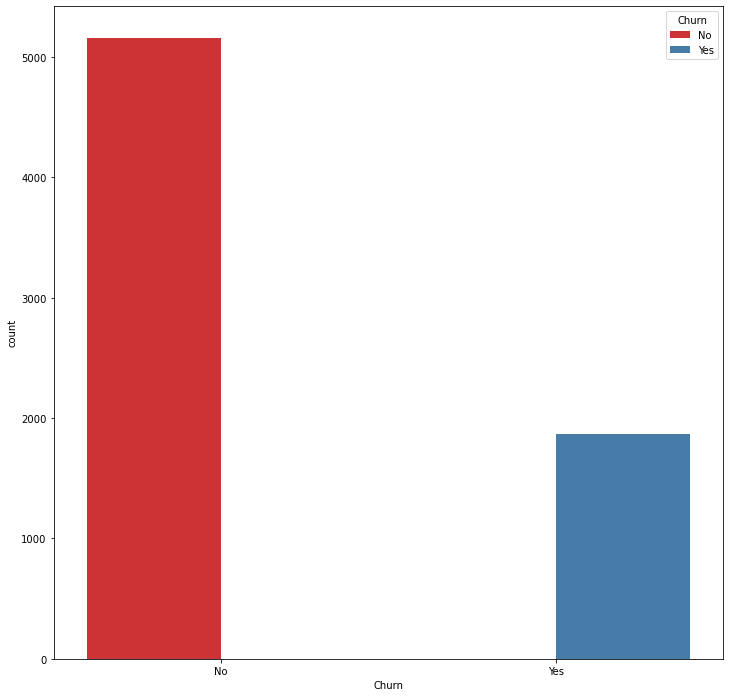

In [345]:
for cat in categorical_features:
    plt.figure(figsize=(12, 12))
    ax = sns.countplot(x=cat, data=data, hue = 'Churn', palette="Set1")

In [373]:
data.head()

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0  Female              0        1           1       1             0   
1    Male              0        0           0      34             1   
2    Male              0        0           1       2             1   
3    Male              0        0           0      45             0   
4  Female              0        0           1       2             1   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL              0            1   
1                No             DSL              1            0   
2                No             DSL              1            1   
3  No phone service             DSL              1            0   
4                No     Fiber optic              0            0   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0                0           0           0               0  Month-to-month   
1                1           0           0               0        One year   
2                0           0           0               0  Month-to-month   
3                1           1           0               0        One year   
4                0           0           0               0  Month-to-month   

   PaperlessBilling              PaymentMethod  MonthlyCharges  TotalCharges  \
0                 1           Electronic check           29.85         29.85   
1                 0               Mailed check           56.95       1889.50   
2                 1               Mailed check           53.85        108.15   
3                 0  Bank transfer (automatic)           42.30       1840.75   
4                 1           Electronic check           70.70        151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [363]:
data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [374]:
features =['gender', 'Partner', 'Dependents',
        'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod']

In [375]:
#convert categorical features into format for algorithms understanding
new_data = pd.get_dummies(data, columns=features)
print(new_data.shape)
new_data.head()

(7032, 46)


SeniorCitizen  tenure  MonthlyCharges  TotalCharges Churn  gender_Female  \
0              0       1           29.85         29.85    No              1   
1              0      34           56.95       1889.50    No              0   
2              0       2           53.85        108.15   Yes              0   
3              0      45           42.30       1840.75    No              0   
4              0       2           70.70        151.65   Yes              1   

   gender_Male  Partner_0  Partner_1  Dependents_0  Dependents_1  \
0            0          0          1             0             1   
1            1          1          0             1             0   
2            1          1          0             0             1   
3            1          1          0             1             0   
4            0          1          0             0             1   

   PhoneService_0  PhoneService_1  MultipleLines_No  \
0               1               0                 0   
1               0               1                 1   
2               0               1                 1   
3               1               0                 0   
4               0               1                 1   

   MultipleLines_No phone service  MultipleLines_Yes  InternetService_DSL  \
0                               1                  0                    1   
1                               0                  0                    1   
2                               0                  0                    1   
3                               1                  0                    1   
4                               0                  0                    0   

   InternetService_Fiber optic  InternetService_No  OnlineSecurity_0  \
0                            0                   0                 1   
1                            0                   0                 0   
2                            0                   0                 0   
3                            0                   0                 0   
4                            1                   0                 1   

   OnlineSecurity_1  OnlineSecurity_No internet service  OnlineBackup_0  \
0                 0                                   0               0   
1                 1                                   0               1   
2                 1                                   0               0   
3                 1                                   0               1   
4                 0                                   0               1   

   OnlineBackup_1  OnlineBackup_No internet service  DeviceProtection_0  \
0               1                                 0                   1   
1               0                                 0                   0   
2               1                                 0                   1   
3               0                                 0                   0   
4               0                                 0                   1   

   DeviceProtection_1  DeviceProtection_No internet service  TechSupport_0  \
0                   0                                     0              1   
1                   1                                     0              1   
2                   0                                     0              1   
3                   1                                     0              0   
4                   0                                     0              1   

   TechSupport_1  TechSupport_No internet service  StreamingTV_0  \
0              0                                0              1   
1              0                                0              1   
2              0                                0              1   
3              1                                0              1   
4              0                                0              1   

   StreamingTV_1  StreamingTV_No internet service  StreamingMovies_0  \
0              0                        

In [376]:
#scaling the features to prevent bias in the model
scale_vars = ['MonthlyCharges', 'TotalCharges','tenure']
scaler = MinMaxScaler()
new_data[scale_vars] = scaler.fit_transform(new_data[scale_vars])
new_data.head()

SeniorCitizen    tenure  MonthlyCharges  TotalCharges Churn  gender_Female  \
0              0  0.000000        0.115423      0.001275    No              1   
1              0  0.464789        0.385075      0.215867    No              0   
2              0  0.014085        0.354229      0.010310   Yes              0   
3              0  0.619718        0.239303      0.210241    No              0   
4              0  0.014085        0.521891      0.015330   Yes              1   

   gender_Male  Partner_0  Partner_1  Dependents_0  Dependents_1  \
0            0          0          1             0             1   
1            1          1          0             1             0   
2            1          1          0             0             1   
3            1          1          0             1             0   
4            0          1          0             0             1   

   PhoneService_0  PhoneService_1  MultipleLines_No  \
0               1               0                 0   
1               0               1                 1   
2               0               1                 1   
3               1               0                 0   
4               0               1                 1   

   MultipleLines_No phone service  MultipleLines_Yes  InternetService_DSL  \
0                               1                  0                    1   
1                               0                  0                    1   
2                               0                  0                    1   
3                               1                  0                    1   
4                               0                  0                    0   

   InternetService_Fiber optic  InternetService_No  OnlineSecurity_0  \
0                            0                   0                 1   
1                            0                   0                 0   
2                            0                   0                 0   
3                            0                   0                 0   
4                            1                   0                 1   

   OnlineSecurity_1  OnlineSecurity_No internet service  OnlineBackup_0  \
0                 0                                   0               0   
1                 1                                   0               1   
2                 1                                   0               0   
3                 1                                   0               1   
4                 0                                   0               1   

   OnlineBackup_1  OnlineBackup_No internet service  DeviceProtection_0  \
0               1                                 0                   1   
1               0                                 0                   0   
2               1                                 0                   1   
3               0                                 0                   0   
4               0                                 0                   1   

   DeviceProtection_1  DeviceProtection_No internet service  TechSupport_0  \
0                   0                                     0              1   
1                   1                                     0              1   
2                   0                                     0              1   
3                   1                                     0              0   
4                   0                                     0              1   

   TechSupport_1  TechSupport_No internet service  StreamingTV_0  \
0              0                                0              1   
1              0                                0              1   
2              0                                0              1   
3              1                                0              1   
4              0                                0              1   

   StreamingTV_1  StreamingTV_No internet service  StreamingMovies_0  \
0              0            

In [377]:
#splitting dataset
X = new_data.drop(columns=['Churn'])
y = new_data['Churn']

In [378]:
#hot encoding the target variable
y =y.replace({'Yes':1,'No':0})

In [379]:
y.value_counts()/len(y)

0    0.734215
1    0.265785
Name: Churn, dtype: float64

In [380]:
#split data inot training and testing, with a kfold of 5
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)
kfold_validation=KFold(5)

In [381]:
def plot_confusion_matrix(cm, classes=None, title='Confusion matrix'):
    if classes is not None:
        sns.heatmap(cm, xticklabels=classes, yticklabels=classes, vmin=0., vmax=1., annot=True, annot_kws={'size':40})
    else:
        sns.heatmap(cm, vmin=0., vmax=1.)
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Machine Learning modelling

### Random Forest

[0.79459844 0.78109453 0.77169275 0.78449502 0.79445235]
The Accuracy of the Random Forest Model is  78.52666155101348
The F1 score of the Random Forest Model is  56.534954407294826


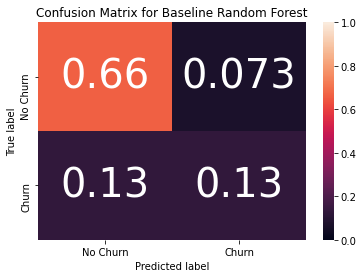

In [382]:
#Baseline Random forest model 
Rf = RandomForestClassifier()
Rf.fit(X_train, y_train)
Rf_pred = Rf.predict(X_test)

K=KFold(5)
results=cross_val_score(Rf,X,y,cv=K)
print(results)
print('The Accuracy of the Random Forest Model is ',np.mean(results)*100)
print('The F1 score of the Random Forest Model is ',f1_score(y_test, Rf_pred,average="binary")*100)


cm = confusion_matrix(y_test, Rf_pred)
cm_norm = cm/np.sum(cm)
plot_confusion_matrix(cm_norm, classes=['No Churn','Churn'], title='Confusion Matrix for Baseline Random Forest');


F1 score with max features = 1,max_depth = None ,criterion = gini: 54.77
F1 score with max features = 1,max_depth = None ,criterion = entropy: 54.46
F1 score with max features = 1,max_depth = 2 ,criterion = gini: 0.00
F1 score with max features = 1,max_depth = 2 ,criterion = entropy: 0.00
F1 score with max features = 1,max_depth = 3 ,criterion = gini: 0.00
F1 score with max features = 1,max_depth = 3 ,criterion = entropy: 0.00
F1 score with max features = 1,max_depth = 4 ,criterion = gini: 7.27
F1 score with max features = 1,max_depth = 4 ,criterion = entropy: 6.79
F1 score with max features = 1,max_depth = 5 ,criterion = gini: 24.49
F1 score with max features = 1,max_depth = 5 ,criterion = entropy: 25.17
F1 score with max features = sqrt,max_depth = None ,criterion = gini: 56.40
F1 score with max features = sqrt,max_depth = None ,criterion = entropy: 55.74
F1 score with max features = sqrt,max_depth = 2 ,criterion = gini: 20.75
F1 score with max features = sqrt,max_depth = 2 ,criterio

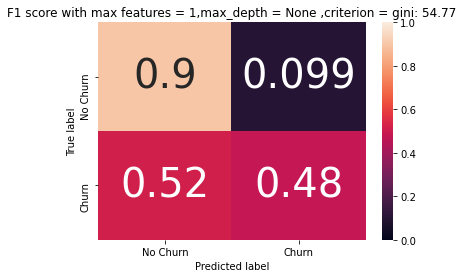

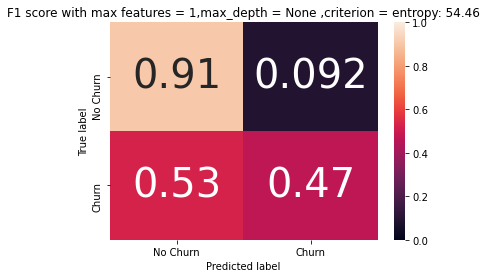

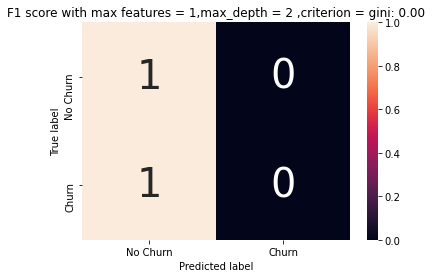

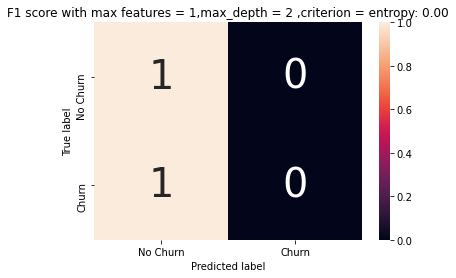

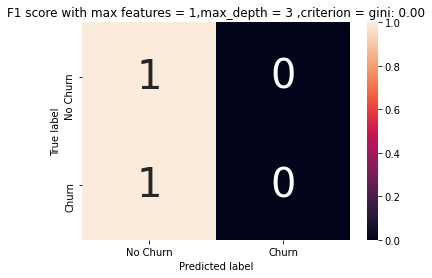

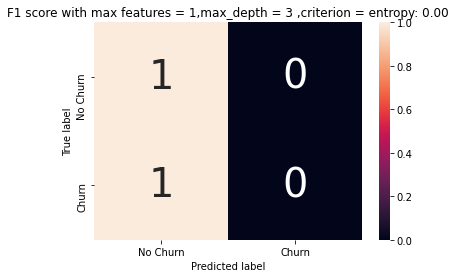

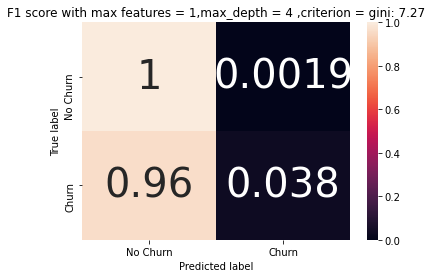

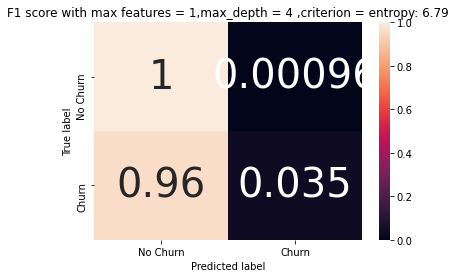

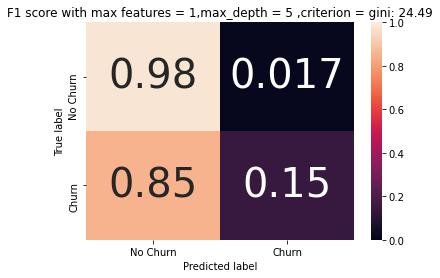

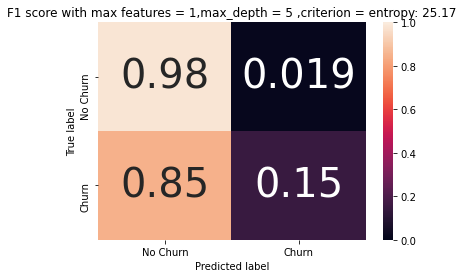

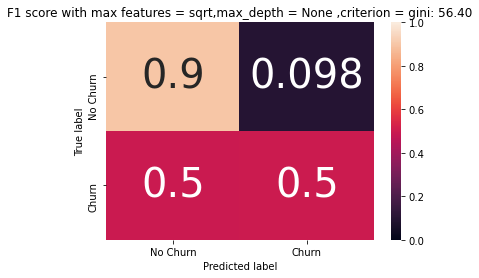

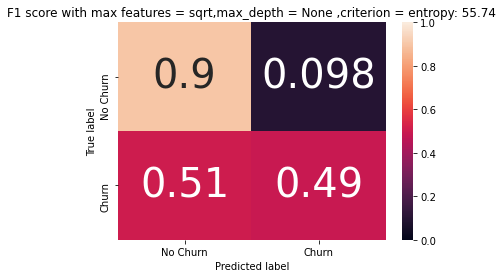

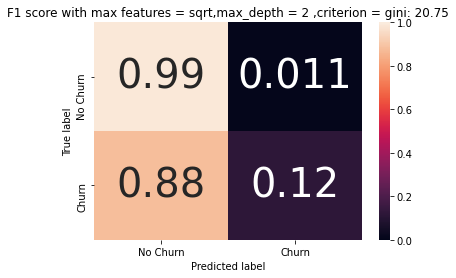

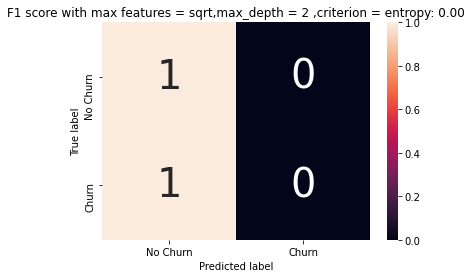

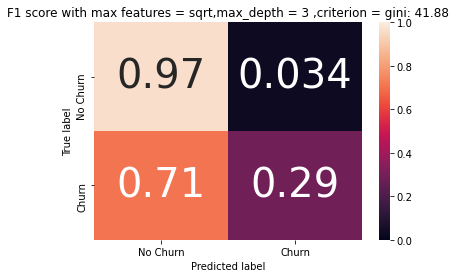

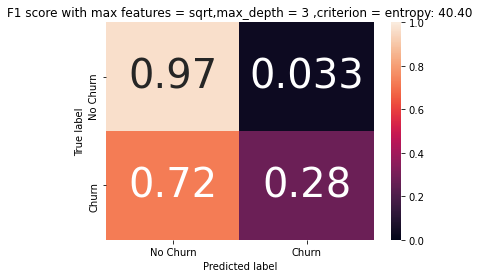

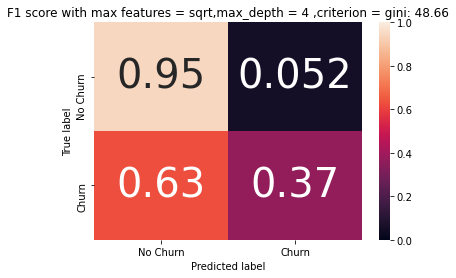

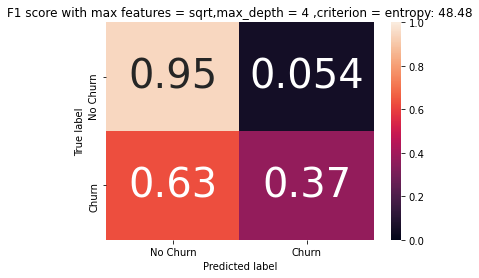

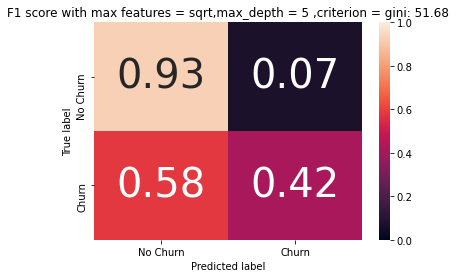

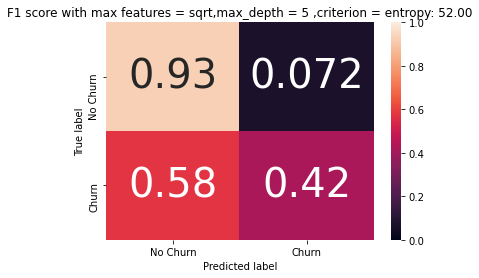

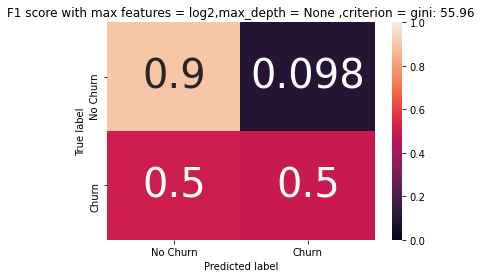

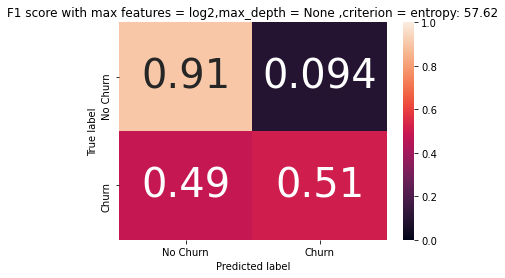

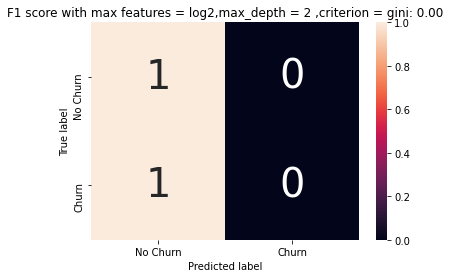

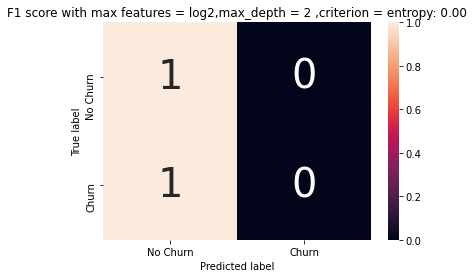

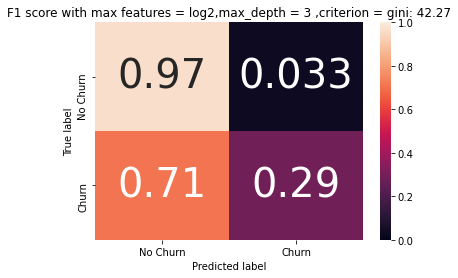

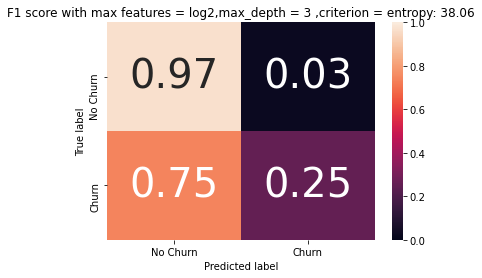

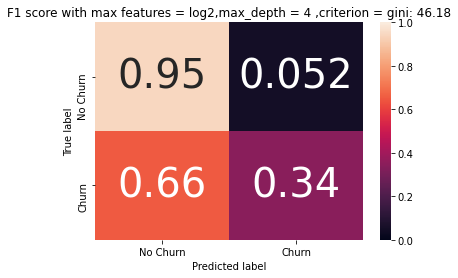

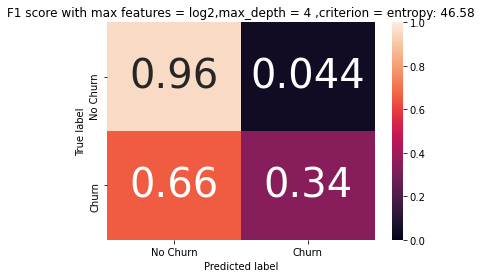

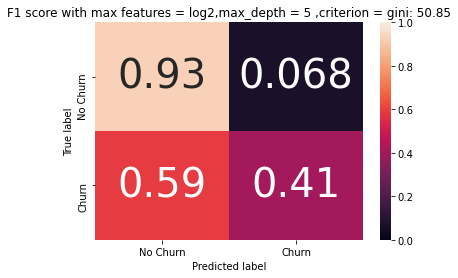

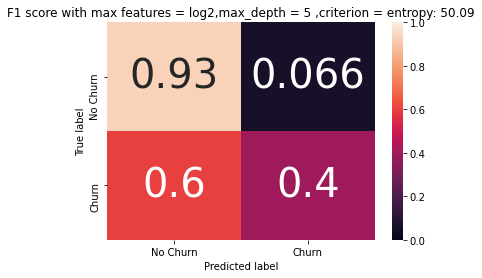

In [383]:
###Hyperparameter tuning of the Random Forest Model
n_estimators = 80
max_features = [1, 'sqrt', 'log2']
criterion=['gini','entropy']
max_depths = [None, 2, 3, 4 , 5]
for f, d, c in product(max_features, max_depths, criterion): 
    Rf = RandomForestClassifier(n_estimators=n_estimators, 
                                criterion=c, 
                                max_features=f, 
                                max_depth=d, 
                                random_state=0)
    Rf.fit(X_train, y_train)
    Rf_pred = Rf.predict(X_test)
    print('F1 score with max features = {},max_depth = {} ,criterion = {}: {:.2f}'.format(f, d, c ,f1_score(y_test,Rf_pred)*100))
    #print('The F1 score of the Random Forest Model after Tuning is ',f1_score(y_test, Rf_pred,average="binary")*100)
    cm = confusion_matrix(y_test, Rf_pred)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=['No Churn','Churn'], 
    title='F1 score with max features = {},max_depth = {} ,criterion = {}: {:.2f}'.format(f, d, c ,f1_score(y_test,Rf_pred)*100))
    

#### The most important variable we are looking for here is to predict more individuals that churned, so the true negatives is where the main focus is. Using the basline random forest, only 13% were identified. The best performance is obtained when the random forest algorithm uses hyperparameters of max features = log2,No max_depth and criterion = entropy, which predicted 51% of individuals that churned, with an f1 score of 57.62%

### XGBOOST

[0.81876333 0.80881308 0.79231863 0.80227596 0.8029872 ]
The Accuracy of the XGBoost Model is  80.50316392028883
The F1 score of the XGBoost Model is  57.674418604651166


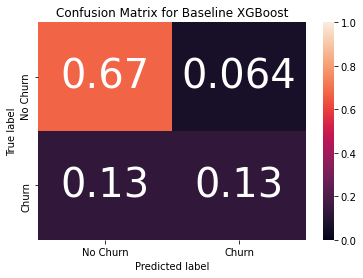

In [384]:
#Baseline Xgboost model
xg = XGBClassifier()
xg.fit(X_train, y_train)
xg_pred = xg.predict(X_test)

K=KFold(5)
results=cross_val_score(xg,X,y,cv=K)
print(results)
print('The Accuracy of the XGBoost Model is ',np.mean(results)*100)
print('The F1 score of the XGBoost Model is ',f1_score(y_test, xg_pred,average="binary")*100)

cm = confusion_matrix(y_test, xg_pred)
cm_norm = cm/np.sum(cm)
plot_confusion_matrix(cm_norm, classes=['No Churn','Churn'], title='Confusion Matrix for Baseline XGBoost')

F1 score with learning_rate = 0.01,max_depth = 2 ,n_estimators = 50: 50.56
F1 score with learning_rate = 0.01,max_depth = 2 ,n_estimators = 70: 48.24
F1 score with learning_rate = 0.01,max_depth = 2 ,n_estimators = 100: 45.07
F1 score with learning_rate = 0.01,max_depth = 2 ,n_estimators = 120: 43.10
F1 score with learning_rate = 0.01,max_depth = 2 ,n_estimators = 150: 47.23
F1 score with learning_rate = 0.01,max_depth = 3 ,n_estimators = 50: 49.06
F1 score with learning_rate = 0.01,max_depth = 3 ,n_estimators = 70: 52.72
F1 score with learning_rate = 0.01,max_depth = 3 ,n_estimators = 100: 54.52
F1 score with learning_rate = 0.01,max_depth = 3 ,n_estimators = 120: 53.98
F1 score with learning_rate = 0.01,max_depth = 3 ,n_estimators = 150: 54.05
F1 score with learning_rate = 0.01,max_depth = 5 ,n_estimators = 50: 56.89
F1 score with learning_rate = 0.01,max_depth = 5 ,n_estimators = 70: 55.49
F1 score with learning_rate = 0.01,max_depth = 5 ,n_estimators = 100: 56.32
F1 score with lear

F1 score with learning_rate = 0.3,max_depth = 3 ,n_estimators = 150: 60.24
F1 score with learning_rate = 0.3,max_depth = 5 ,n_estimators = 50: 57.44
F1 score with learning_rate = 0.3,max_depth = 5 ,n_estimators = 70: 55.98
F1 score with learning_rate = 0.3,max_depth = 5 ,n_estimators = 100: 55.61
F1 score with learning_rate = 0.3,max_depth = 5 ,n_estimators = 120: 56.72
F1 score with learning_rate = 0.3,max_depth = 5 ,n_estimators = 150: 55.14
F1 score with learning_rate = 0.3,max_depth = 7 ,n_estimators = 50: 56.64
F1 score with learning_rate = 0.3,max_depth = 7 ,n_estimators = 70: 56.30
F1 score with learning_rate = 0.3,max_depth = 7 ,n_estimators = 100: 55.59
F1 score with learning_rate = 0.3,max_depth = 7 ,n_estimators = 120: 55.59
F1 score with learning_rate = 0.3,max_depth = 7 ,n_estimators = 150: 55.29
F1 score with learning_rate = 0.3,max_depth = 9 ,n_estimators = 50: 55.38
F1 score with learning_rate = 0.3,max_depth = 9 ,n_estimators = 70: 54.86
F1 score with learning_rate = 0

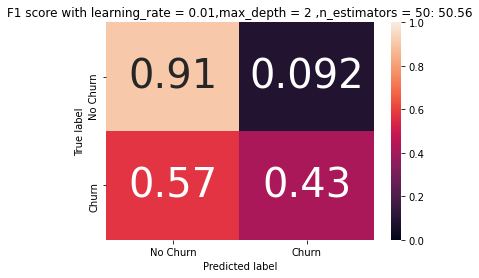

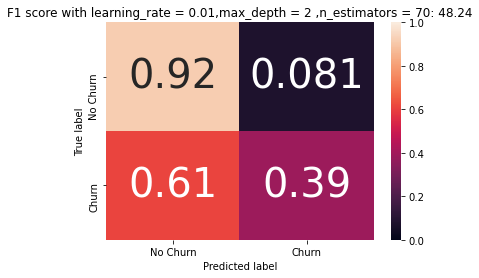

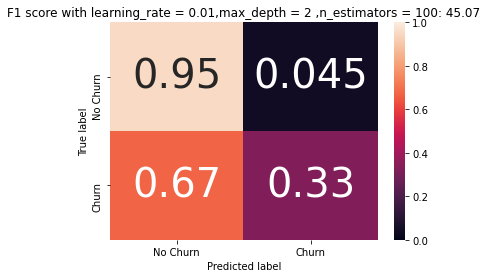

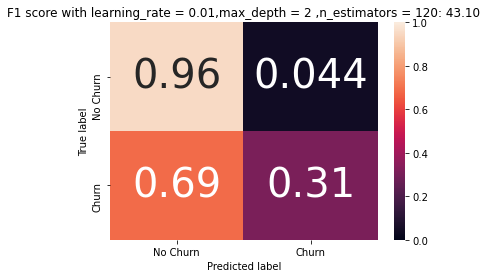

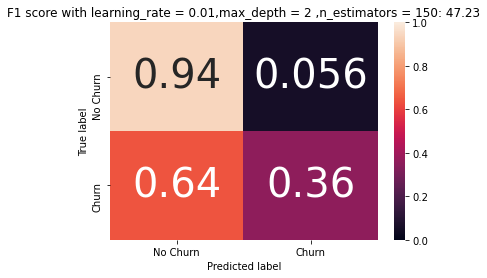

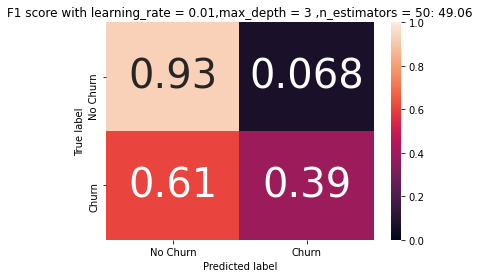

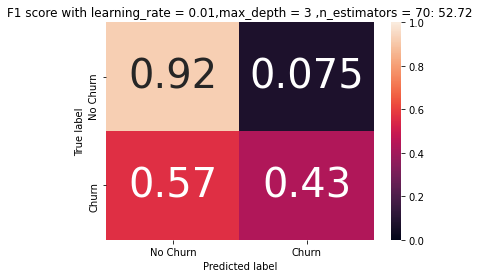

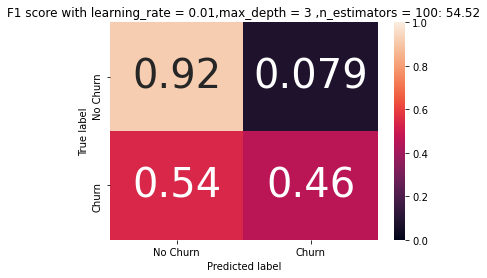

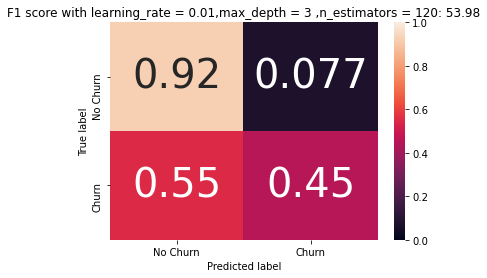

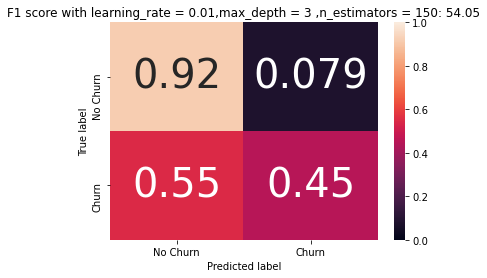

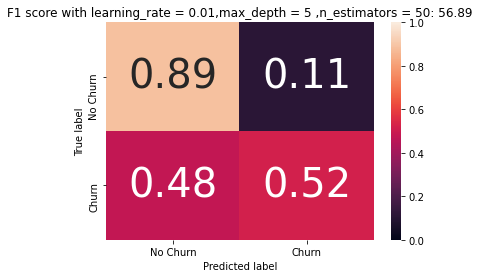

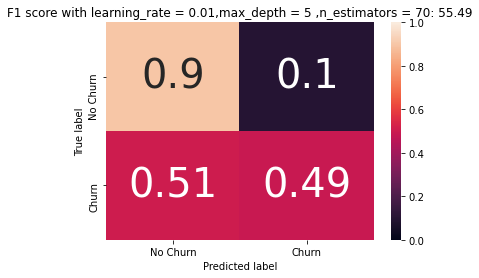

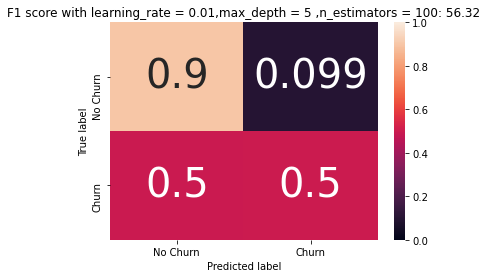

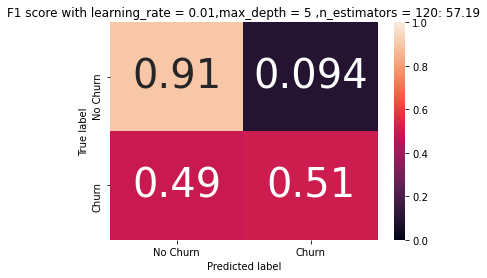

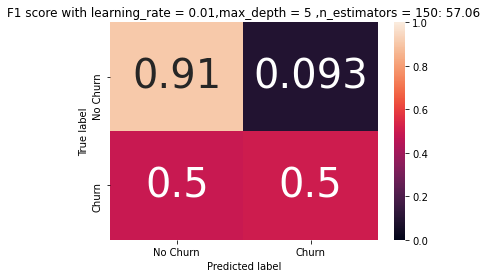

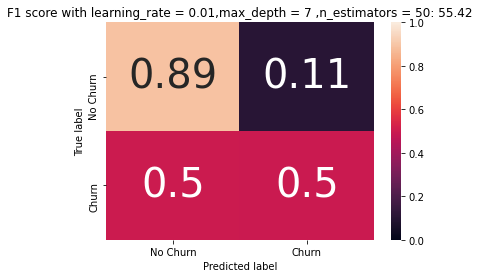

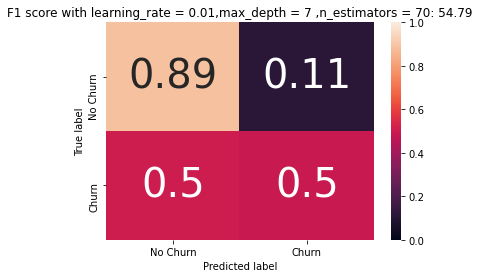

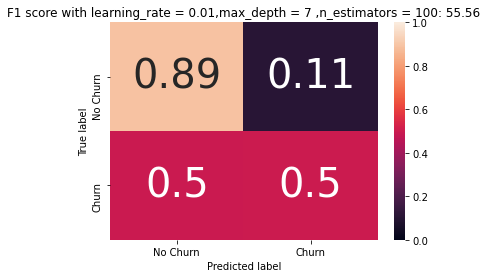

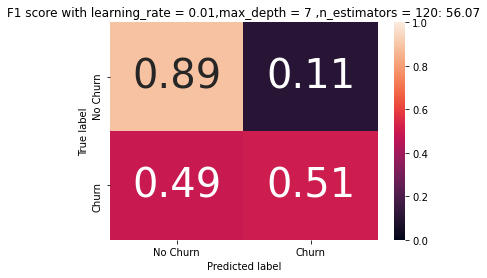

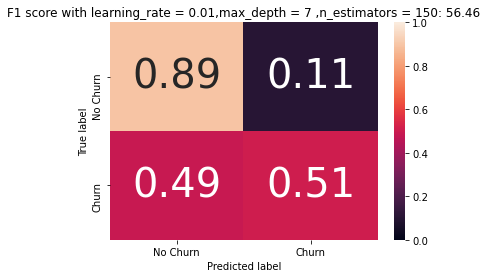

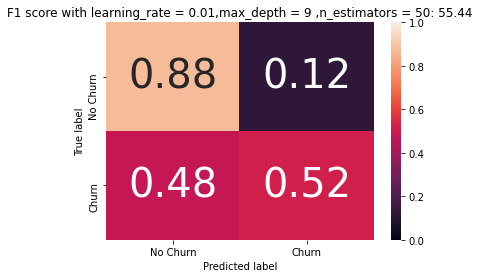

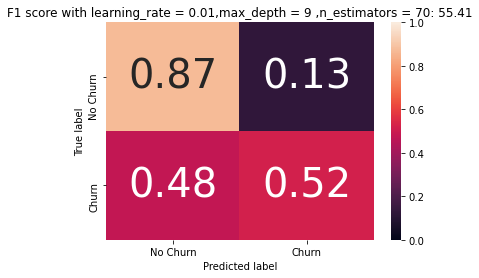

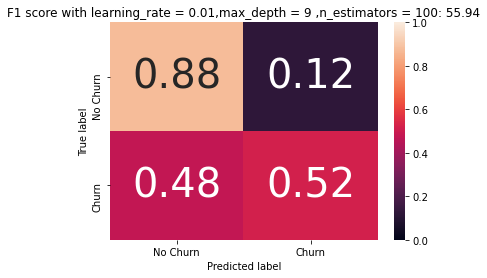

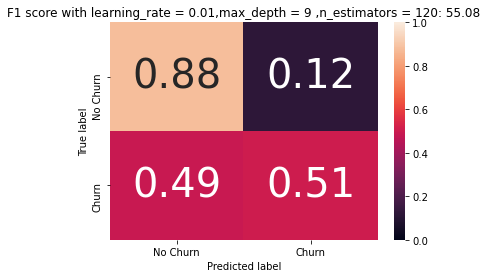

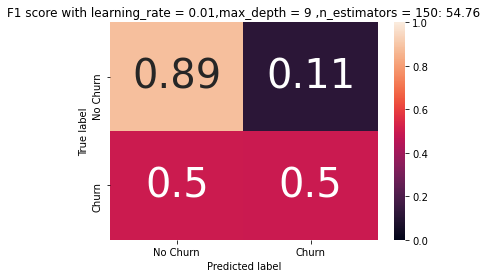

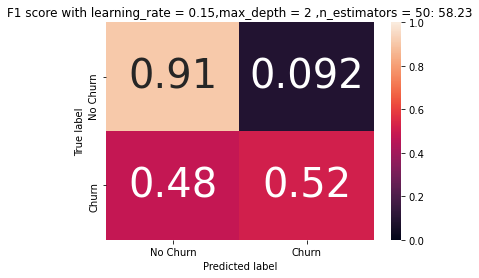

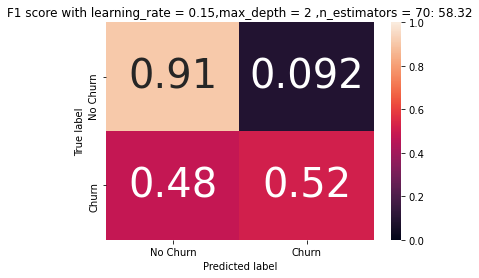

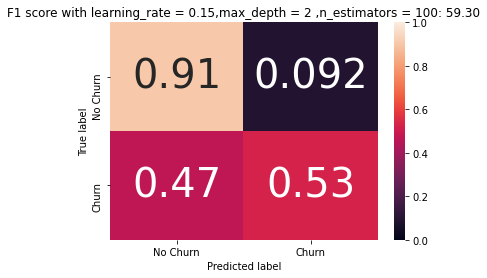

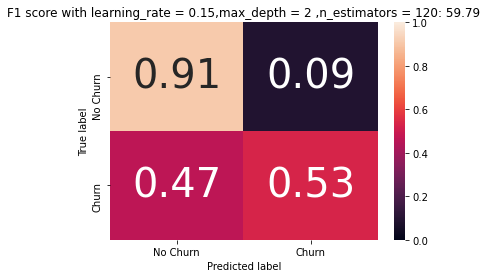

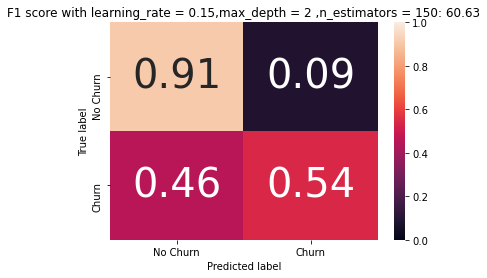

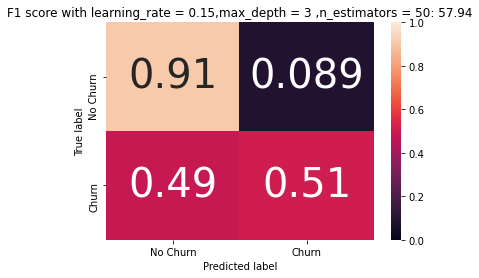

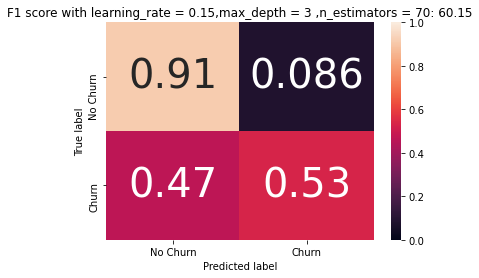

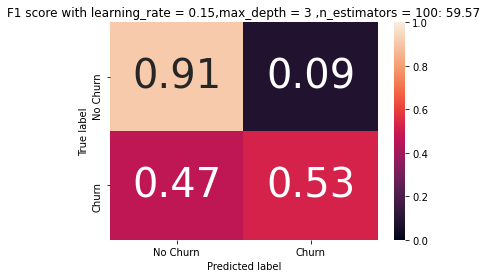

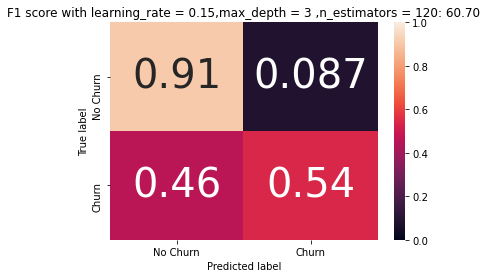

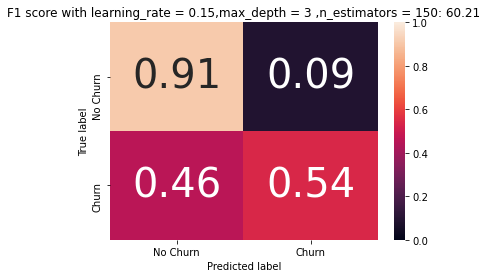

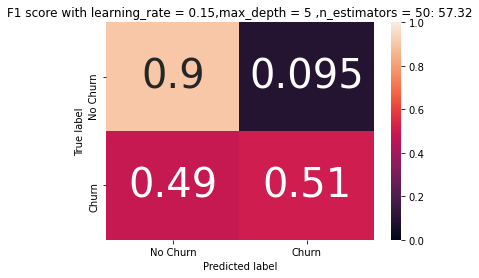

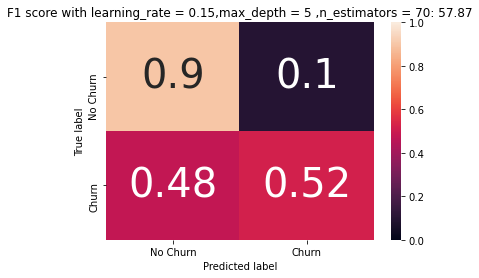

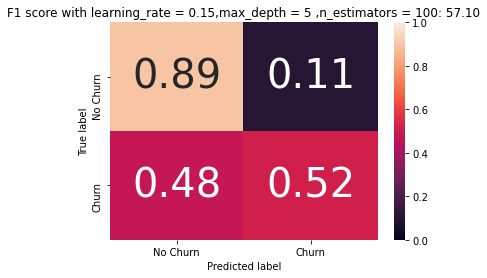

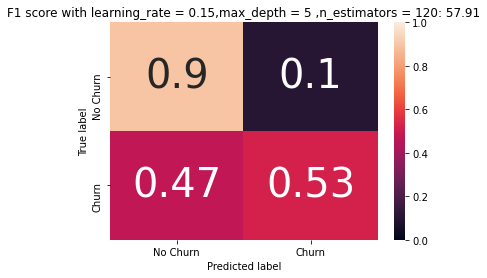

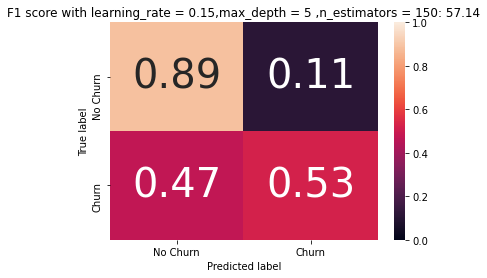

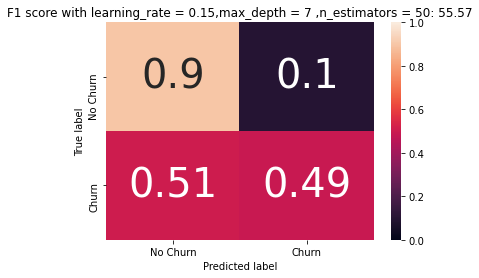

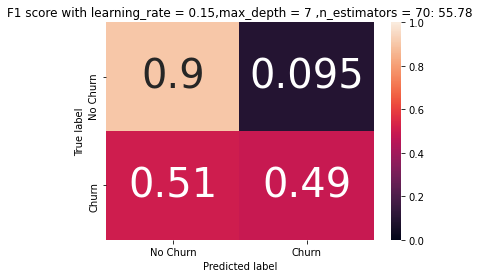

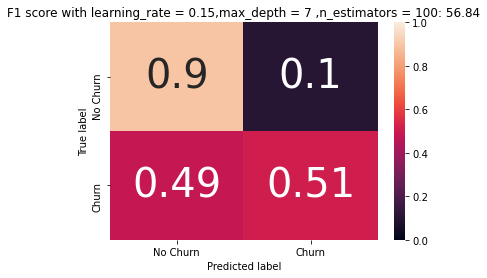

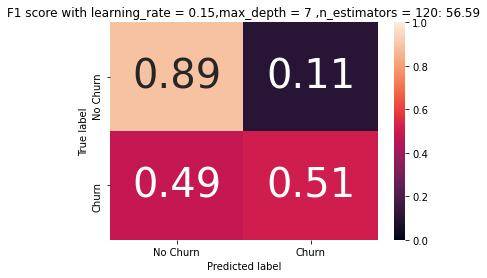

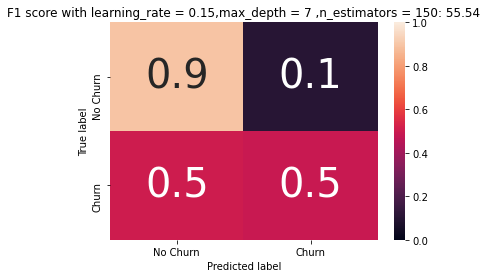

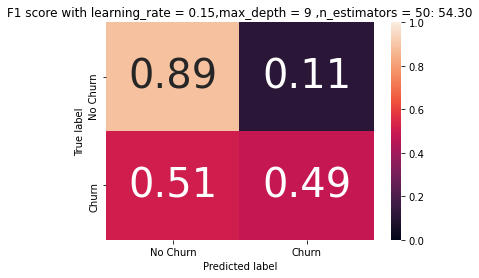

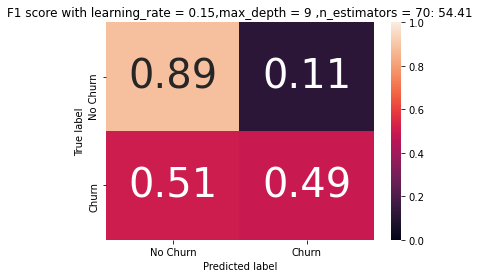

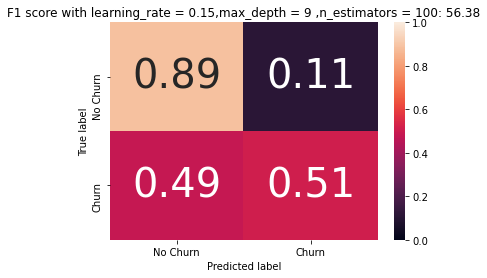

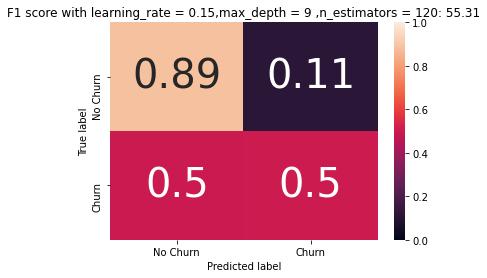

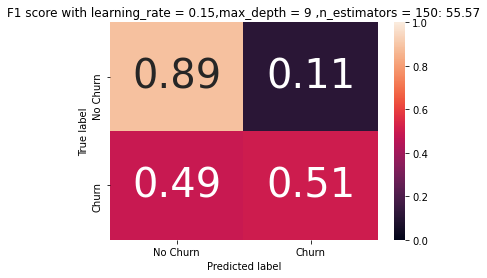

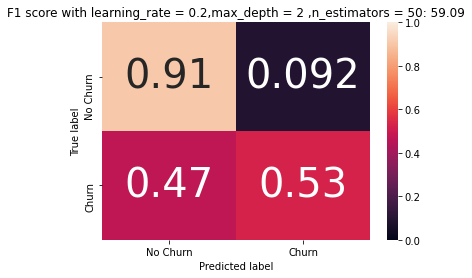

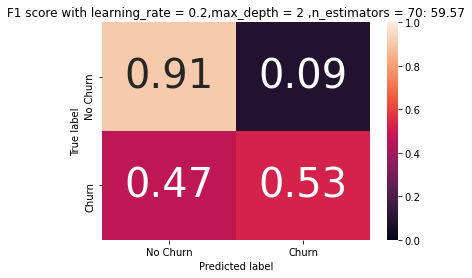

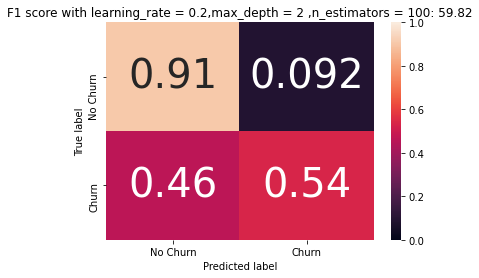

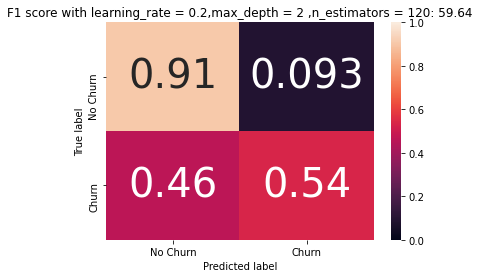

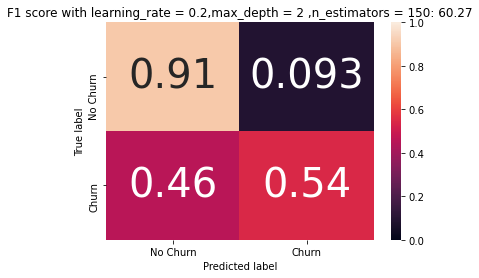

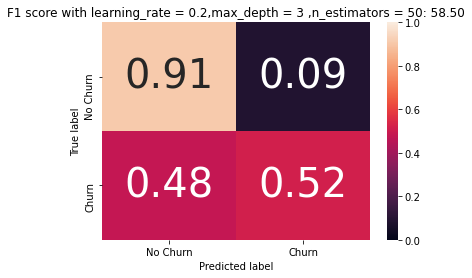

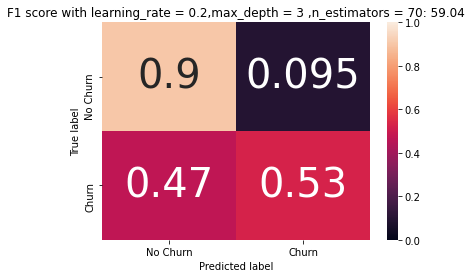

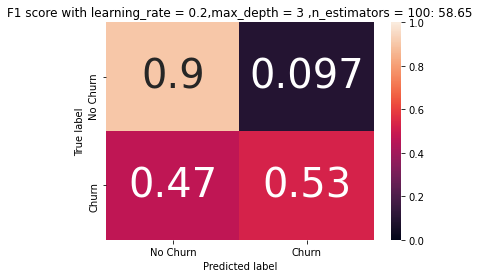

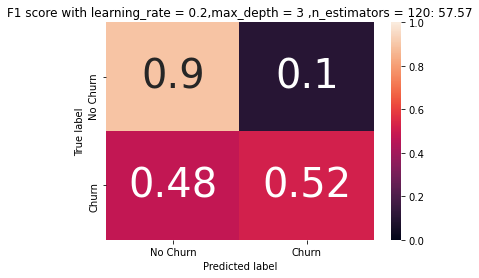

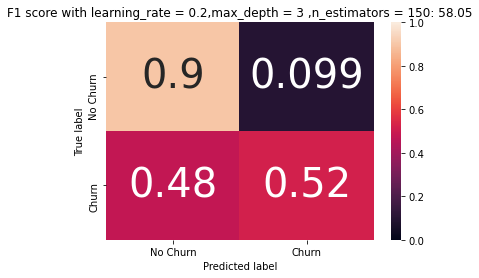

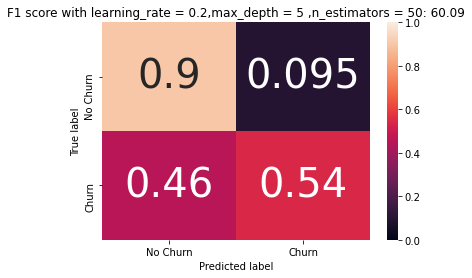

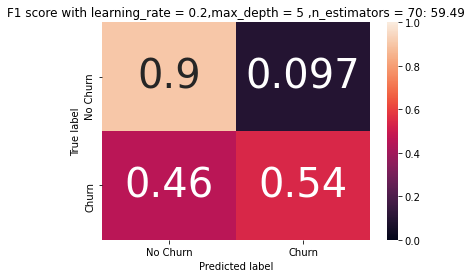

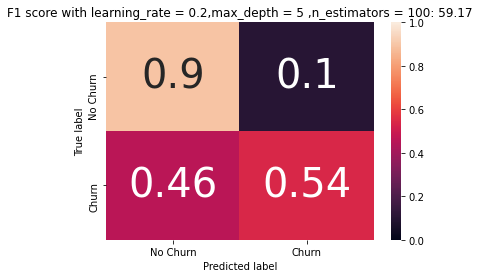

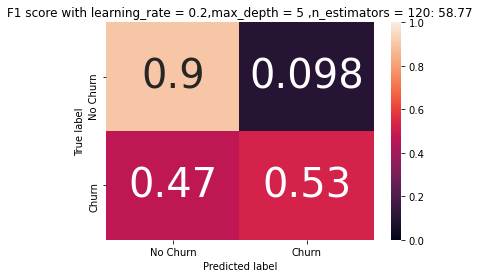

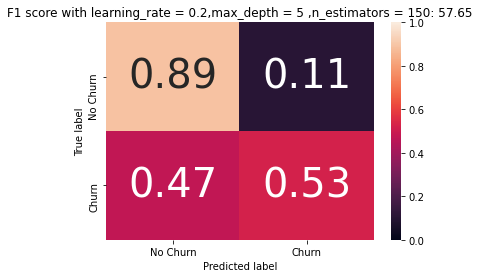

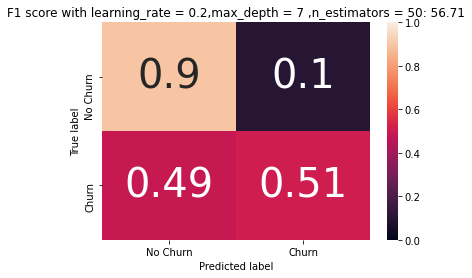

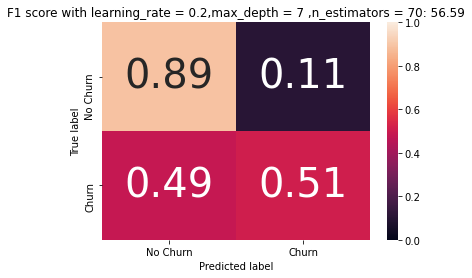

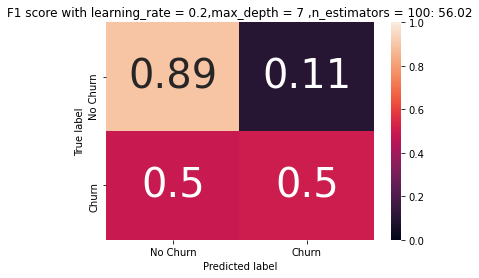

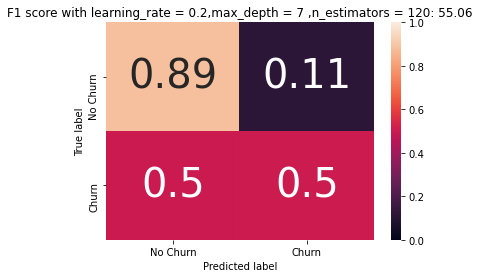

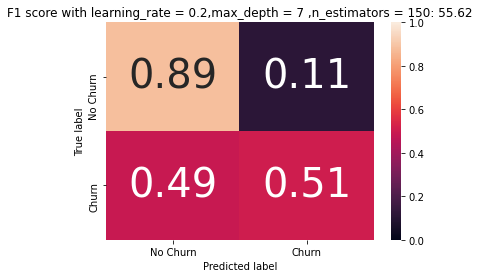

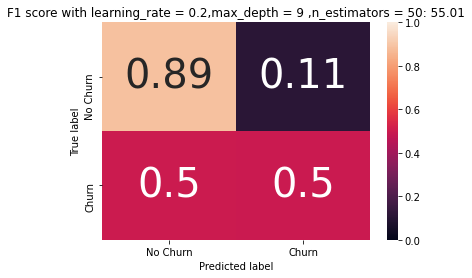

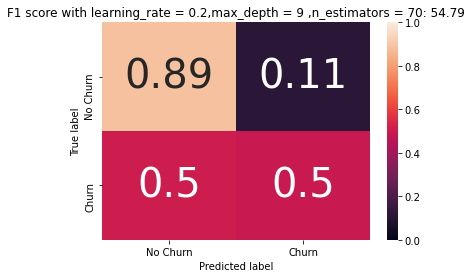

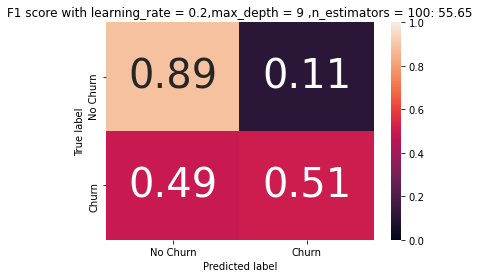

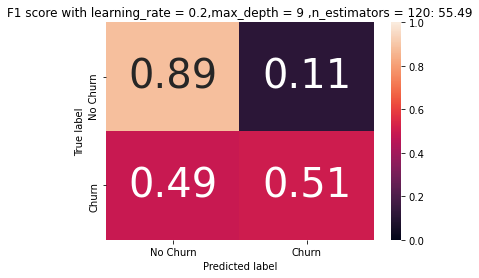

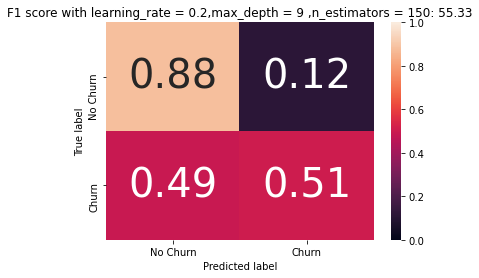

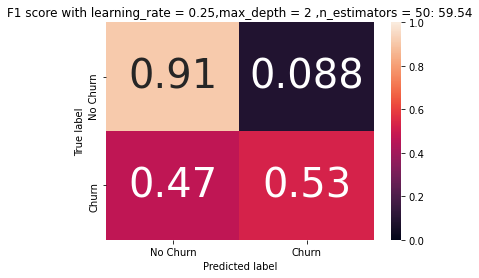

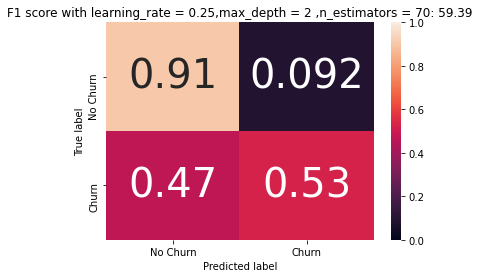

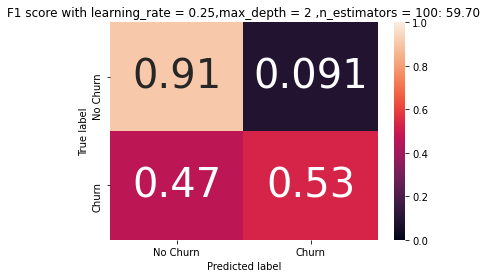

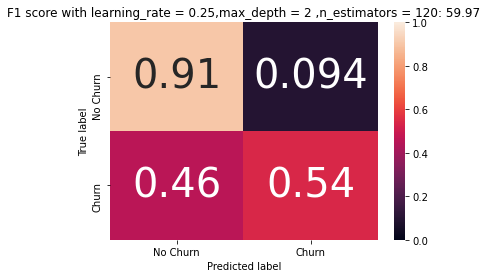

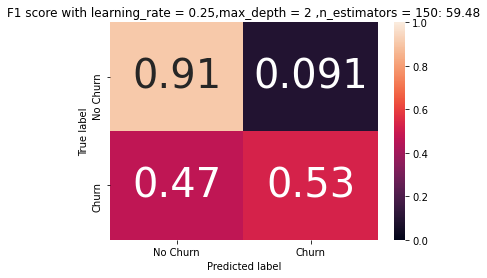

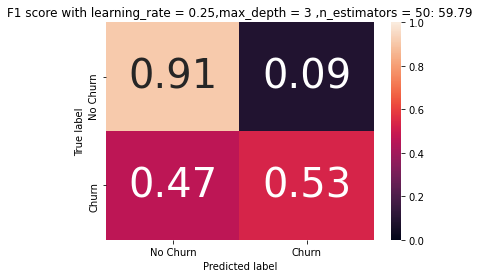

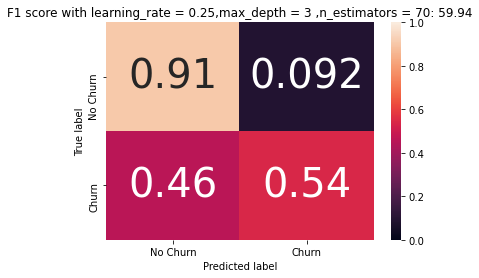

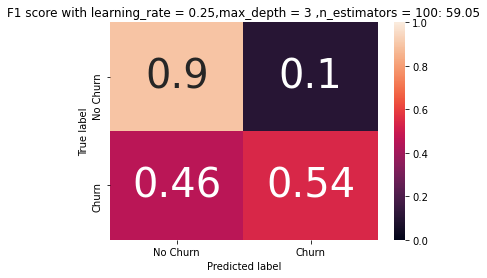

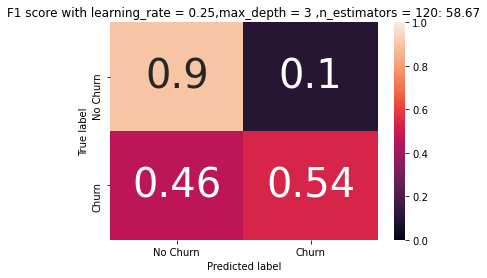

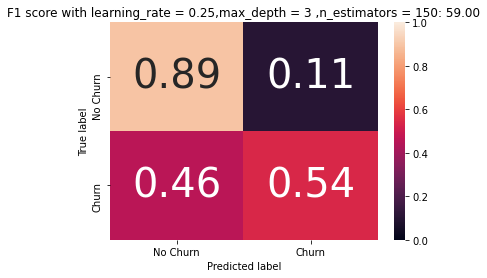

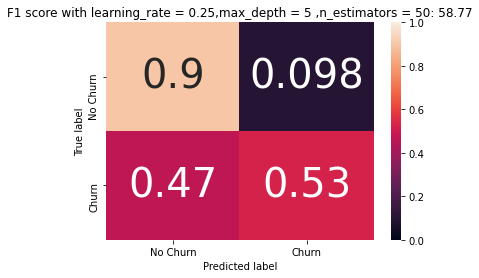

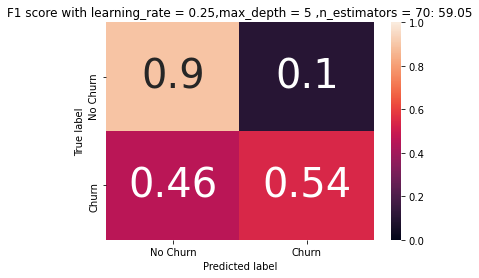

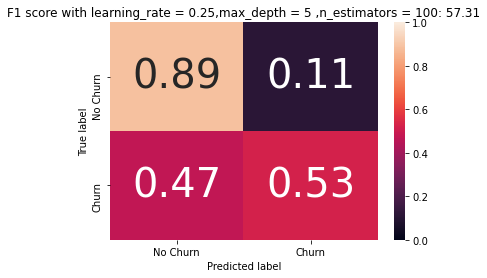

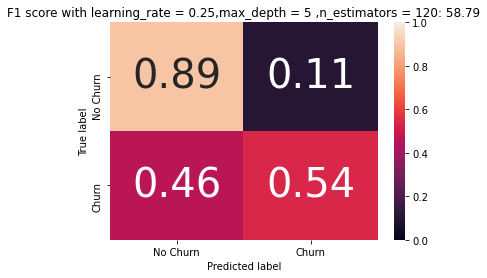

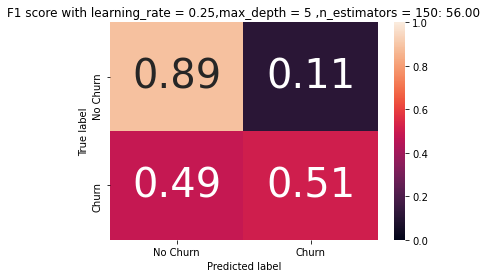

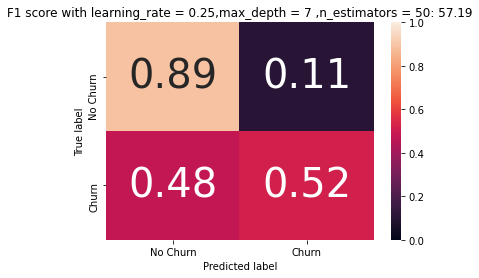

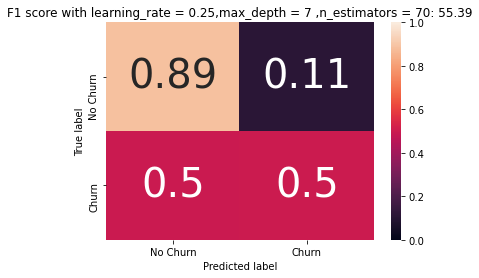

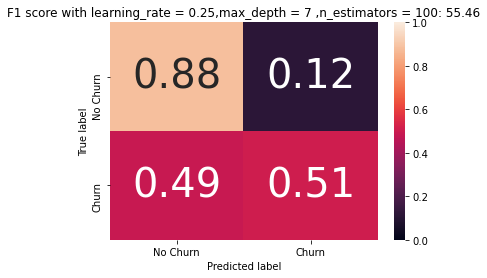

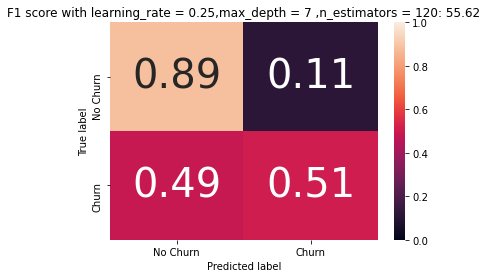

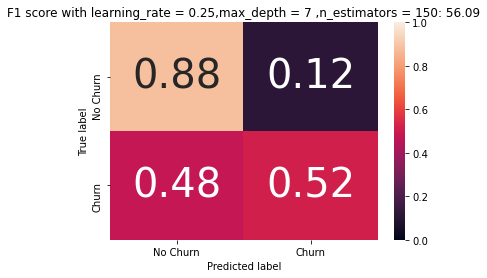

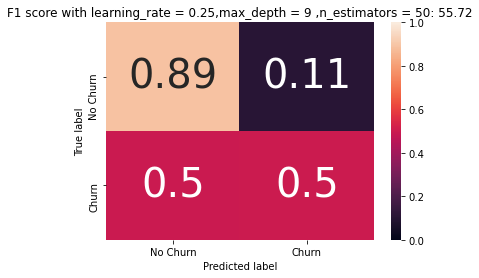

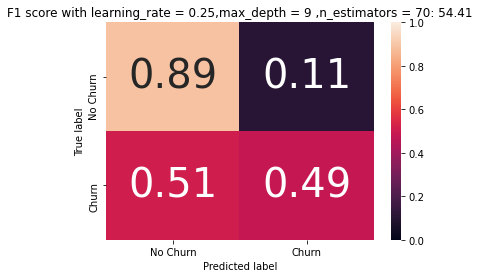

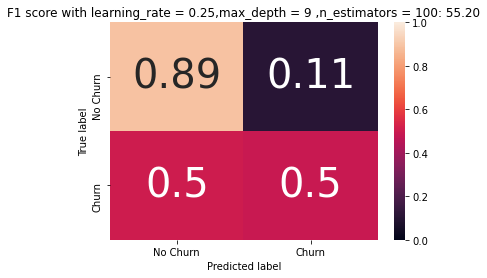

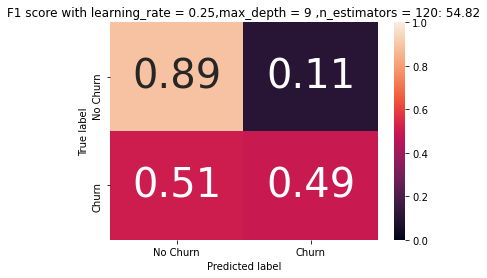

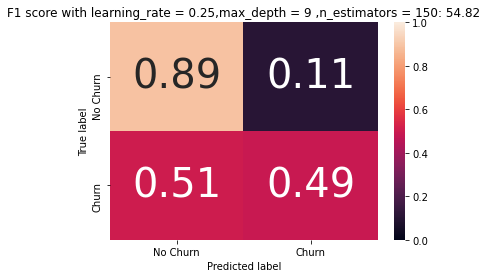

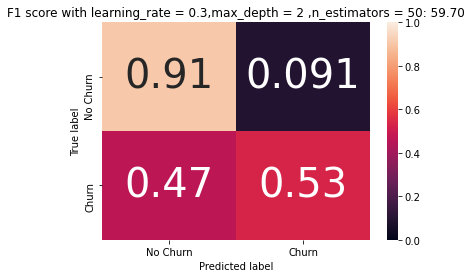

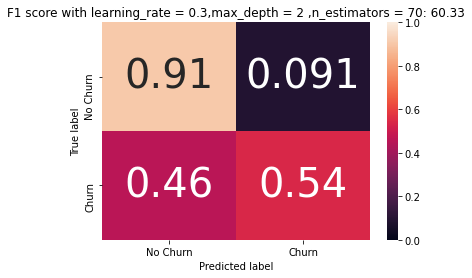

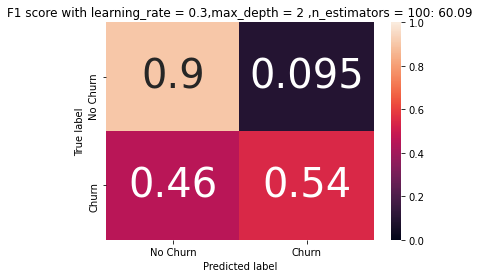

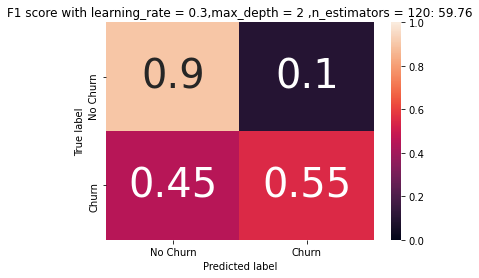

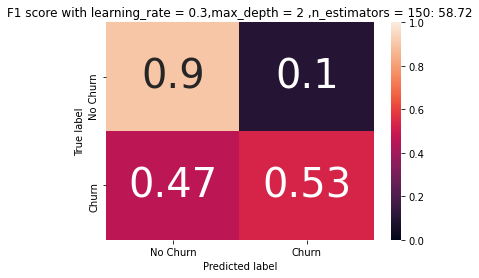

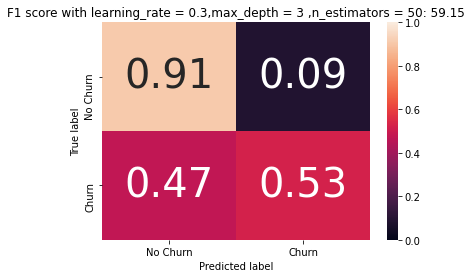

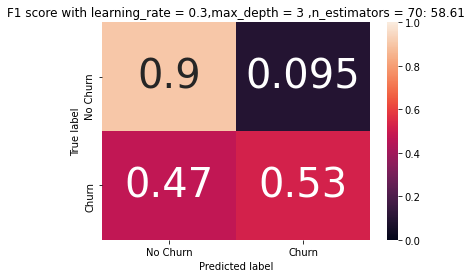

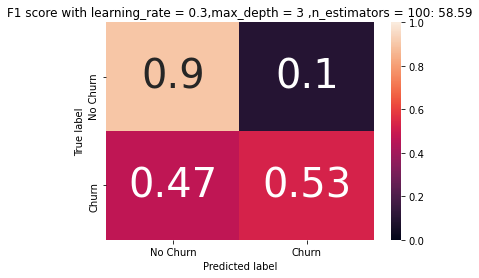

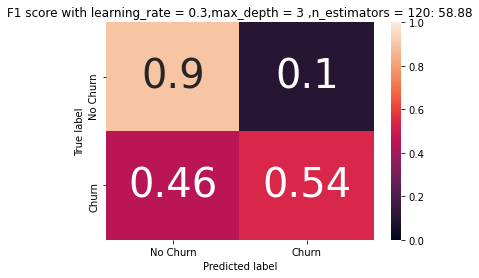

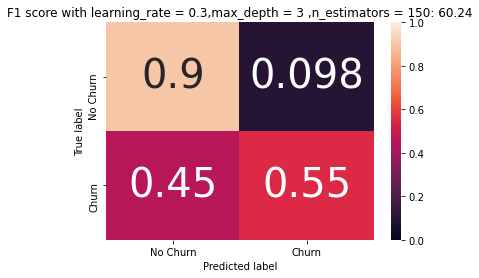

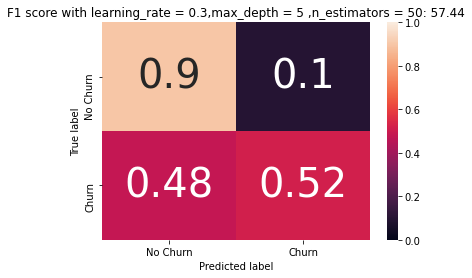

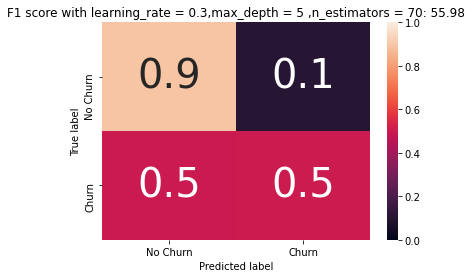

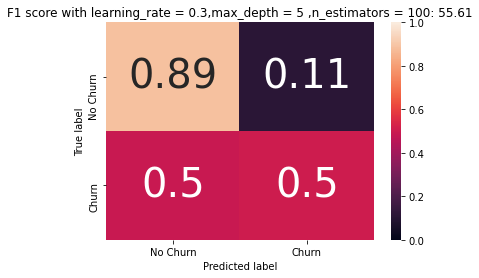

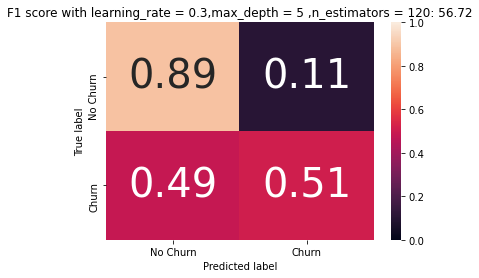

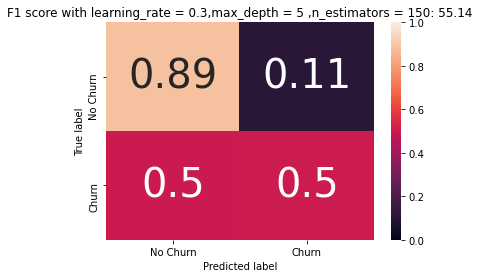

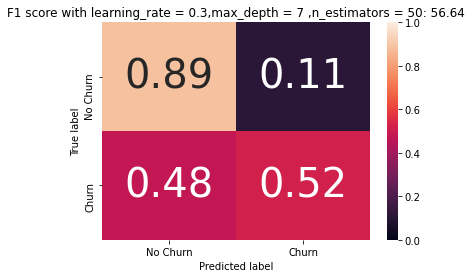

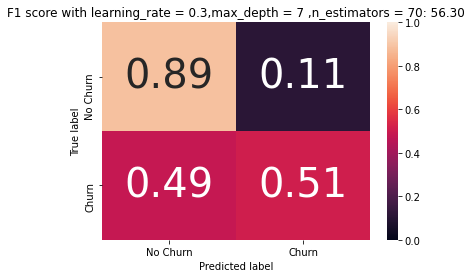

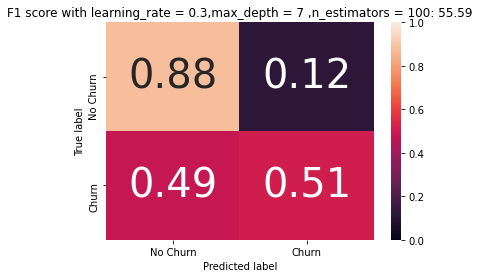

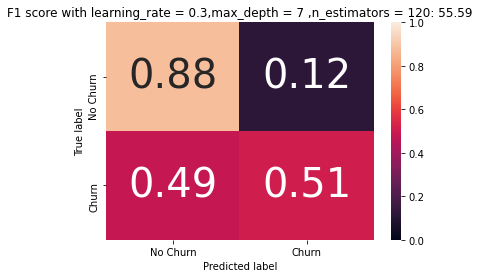

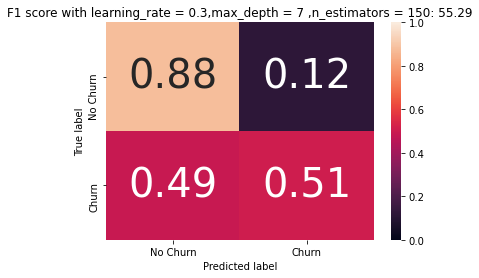

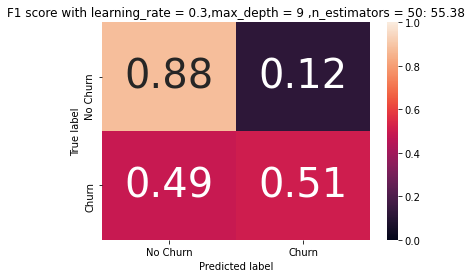

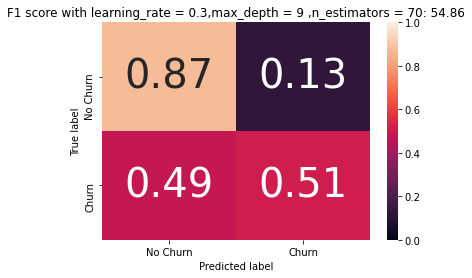

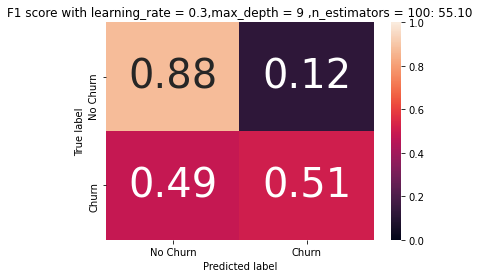

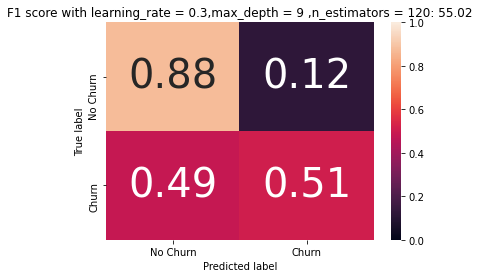

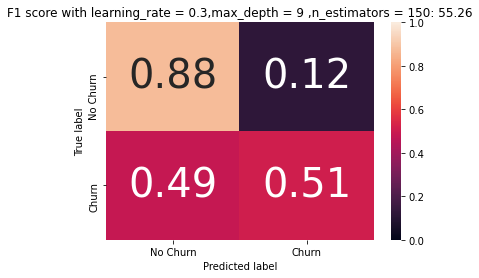

In [385]:
#Optimized Xgboost model
learning_rate=[0.01,0.15,0.2,0.25,0.3]
max_depth = [2,3,5,7,9]
n_estimators=[50,70,100,120,150]
for l, m, n in product(learning_rate, max_depth, n_estimators): 
    xg = XGBClassifier(learning_rate=l, 
                                criterion=c, 
                                max_depth=m, 
                                n_estimators=n, 
                                random_state=0)
    xg.fit(X_train, y_train)
    xg_pred = xg.predict(X_test)
    print('F1 score with learning_rate = {},max_depth = {} ,n_estimators = {}: {:.2f}'.format(l, m, n ,f1_score(y_test,xg_pred)*100))
    #print('The F1 score of the Random Forest Model after Tuning is ',f1_score(y_test, Rf_pred,average="binary")*100)
    cm = confusion_matrix(y_test, xg_pred)
    cm_norm = cm/cm.sum(axis=1)[:, np.newaxis]
    plt.figure()
    plot_confusion_matrix(cm_norm, classes=['No Churn','Churn'], 
    title='F1 score with learning_rate = {},max_depth = {} ,n_estimators = {}: {:.2f}'.format(l, m, n ,f1_score(y_test,xg_pred)*100))
    

#### The most important variable we are looking for here is to predict more individuals that churned, so the true negatives is where the main focus is. Using the baseline XGboost model, also, only 13% were identified. The best performance is obtained when the XGboost algorithm was optimized using learning rate = 0.3, max_depth = 3 and n_estimators = 150, which predicted 55% of individuals that churned with an f1 score of 60.24%, which is better than that of the Random Forest Algorithm. The XGboost model is therefore the algorithm chosen to predict churn

In [405]:
#using the xgboost to make predictions
xg_pred = xg.predict(X)
xg_pred_proba = xg.predict_proba(X)
print(xg_pred)
print(xg_pred_proba)

[0 0 1 ... 0 1 0]
[[0.8671769  0.1328231 ]
 [0.9973029  0.00269713]
 [0.06686574 0.93313426]
 ...
 [0.97030157 0.02969843]
 [0.02600479 0.9739952 ]
 [0.98503494 0.01496503]]


In [401]:
def column(matrix, i):
    return [row[i] for row in matrix]

column(xg_pred_proba, 1)

[0.1328231,
 0.0026971265,
 0.93313426,
 0.0007510862,
 0.9294697,
 0.99795806,
 0.17608221,
 0.023854075,
 0.8761507,
 0.009483392,
 0.009772333,
 0.00033080112,
 0.014103962,
 0.90097386,
 0.7607742,
 0.010988161,
 0.0006658993,
 0.023479095,
 0.78422767,
 0.15396582,
 0.9959746,
 0.005938572,
 0.719951,
 8.3044935e-05,
 0.018286651,
 0.033666622,
 0.9544507,
 0.86984277,
 0.0005503325,
 0.25039747,
 0.0072415373,
 0.9894712,
 0.013612771,
 0.34337866,
 0.7355152,
 0.0014107991,
 0.8798738,
 0.026806619,
 0.83190507,
 0.99397534,
 0.015522247,
 9.8250224e-05,
 0.0002922715,
 0.0013678605,
 0.057608563,
 0.109767474,
 0.051501337,
 0.9133781,
 0.00061268714,
 5.296006e-05,
 0.04416479,
 0.8054966,
 0.044593472,
 0.9131909,
 0.0014155916,
 0.9658809,
 0.07347729,
 0.029542351,
 0.005406613,
 0.00684114,
 0.0526564,
 0.042539787,
 0.0004326552,
 0.008235222,
 0.9777524,
 0.09253177,
 0.027195359,
 0.0012826455,
 0.0009968356,
 0.043327708,
 0.14293735,
 0.0005540538,
 0.0016997593,
 0.0

In [414]:
output_data = data.copy()
output_data['Churn or Not'] = xg_pred
output_data['Probability of Churning'] = column(xg_pred_proba, 1)
output_data['Churn or Not Exp'] = 'Empty'
output_data['Churn or Not Exp'][output_data['Churn or Not'] == 0] = 'Retained'
output_data['Churn or Not Exp'][output_data['Churn or Not'] == 1] = 'Churned'
output_data.head(15)

gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
0   Female              0        1           1       1             0   
1     Male              0        0           0      34             1   
2     Male              0        0           1       2             1   
3     Male              0        0           0      45             0   
4   Female              0        0           1       2             1   
5   Female              0        0           1       8             1   
6     Male              0        0           1      22             1   
7   Female              0        0           0      10             0   
8   Female              0        1           1      28             1   
9     Male              0        0           0      62             1   
10    Male              0        1           1      13             1   
11    Male              0        0           0      16             1   
12    Male              0        1           0      58             1   
13    Male              0        0           1      49             1   
14    Male              0        0           1      25             1   

       MultipleLines InternetService       OnlineSecurity  \
0   No phone service             DSL                    0   
1                 No             DSL                    1   
2                 No             DSL                    1   
3   No phone service             DSL                    1   
4                 No     Fiber optic                    0   
5                Yes     Fiber optic                    0   
6                Yes     Fiber optic                    0   
7   No phone service             DSL                    1   
8                Yes     Fiber optic                    0   
9                 No             DSL                    1   
10                No             DSL                    1   
11                No              No  No internet service   
12               Yes     Fiber optic                    0   
13               Yes     Fiber optic                    0   
14                No     Fiber optic                    1   

           OnlineBackup     DeviceProtection          TechSupport  \
0                     1                    0                    0   
1                     0                    1                    0   
2                     1                    0                    0   
3                     0                    1                    1   
4                     0                    0                    0   
5                     0                    1                    0   
6                     1                    0                    0   
7                     0                    0                    0   
8                     0                    1                    1   
9                     1                    0                    0   
10                    0                    0                    0   
11  No internet service  No internet service  No internet service   
12                    0                    1                    0   
13                    1                    1                    0   
14                    0                    1                    1   

            StreamingTV      StreamingMovies        Contract  \
0                     0                    0  Month-to-month   
1                     0                    0        One year   
2                     0                    0  Month-to-month   
3                     0                    0        One year   
4                     0                    0  Month-to-month   
5                     1                    1  Month-to-month   
6                     1                    0  Month-to-month   
7                     0                    0  Month-to-month   
8                     1                    1  Month-to-month   
9                     0                    0        One year   
10                    0                    0  Month-to-month   
1

In [415]:
# Export data to csv file
output_data.to_csv('Final_model.csv')